This notebook compares annotations using different GLLMs with codebooks based prompts of Boukes 2024, Jaidka 2022 and Naab 2025 on their respective datasets

In [1]:
import requests
import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time

import typing

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import pandas as pd

import config
import src
import tqdm
import json
import numpy as np
import logging

#import cltrier_lib as lib
import pyreadstat
import yaml
pd.set_option('display.max_colwidth', 100) 
#set up helper variables and functions:
CFG = config.Config()

import matplotlib.pyplot as plt
import itertools
from matplotlib_venn import venn3
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import warnings
warnings.filterwarnings('ignore')



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\sstolwi\Git

In [2]:
# Define the mapping from concept to ground truth column
boukes_concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

# Helper: get ground truth column for a concept
def get_ground_truth_col(concept):
    for c, col in boukes_concepts_info:
        if c.lower() == concept.lower():
            return col
    raise ValueError(f"No ground truth column for concept: {concept}")

# Example usage: get_ground_truth_col('Incivility') -> 'INCIVILITY_DUMMY'

In [3]:
#load data:

# Jaida2024 data
jaidka = pd.read_parquet('data/jaidka2022/TwitterDeliberativePolitics2.parquet')
# Boukes
boukes = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')
boukesT = pd.read_csv('data/publicsphere/full_data.csv') # this includes the comments
#the Boukes2024 data is a subset of this, select YT part of Boukes in line with Boukes2024:
boukesTYT = boukesT[boukesT['Platform'] == 1]
#select Boukes paper data:
boukes2024 = boukes.loc[~boukes.topic.isna(),:]
#MH_clemm 2024
MHclemm = pd.read_parquet('data/MH_BClemm_data/Ideo_Val_GPT_USA_L33_70b.parquet')


In [4]:
# Define mapping for genre_paper
regular_news = [
    'CBS Evening News ', '60 Minutes', 'CBSEveningNews', 'MeetThePress', 'CBS Evening News', 'World News Tonight', 'ABC Nightline ',
    'NBC News', 'Face the Nation', 'World News Tonight With David Muir', 'NBCNews', 'ABCWorldNews', '60Minutes', 'FaceTheNation',
    'Meet The Press', 'ABC News', 'NightLine'
]
satire = [
    'colbertlateshow', 'Late Show with Colbert', 'Daily Show', 'Full Frontal with Samantha Bee ', 'Last week Tonight', 'Real Time with Bill Maher ',
    'FullFrontalSamB', 'Late Night with Seth Meyers ', 'Patriot Act with Hasan Minhaj', 'LastWeekTonight', 'patriotact', 'Full Frontal with Samantha Bee',
    'Patriot Act', 'TheDailyShow', 'LateNightSeth', 'Late Night with Seth Meyers', 'The Daily Show with Trevor Noah', 'Real Time with Bill Maher',
    'The Late Show with Stephen Colbert', 'RealTimers'
]
conservative_partisan_news = [
    'Hannity', 'Fox News', 'Hannity (FoxNews)', 'Tucker Carlson Tonight (FoxNews)', 'Tucker Carlson Tonight', 'TuckerCarlson'
]
liberal_partisan_news = [
    'The 11th Hour', 'Hardball with Chris Matthews (MSNBC)', 'Anderson Cooper 360 (CNN)', 'hardball', 'Anderson Cooper 360',
    'MSNBC', 'Hardball with Chris Matthews', 'AC360', '11thHour', 'CNN'
]
unknown = ['NewsHour']

# Function to map Genre to genre_paper
def map_genre_to_paper(genre):
    if genre in regular_news:
        return 'regular news'
    elif genre in satire:
        return 'satire'
    elif genre in conservative_partisan_news:
        return 'conservative partisan news'
    elif genre in liberal_partisan_news:
        return 'liberal partisan news'
    elif genre in unknown:
        return 'unknown'
    else:
        return 'other'

# Apply mapping to create genre_paper column
boukes['genre_paper'] = boukes['showName'].apply(map_genre_to_paper)
boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)


In [9]:
#define functions:

def get_labels(model_col):
    labels = {
        'concept': '',
        'model': '',
        'temperature': '',
        'seed': '',
        'run': '',
        'prompt_variant': ''
    }
    if 'rationality' in model_col:
        labels['concept'] = 'Rationality'
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        labels['concept'] = 'Interactivity'
    if 'political_post' in model_col:
        labels['concept'] = 'Political Post'
    if '_con' in model_col:
        labels['concept'] = 'Conservative'
    if '_lib' in model_col:
        labels['concept'] = 'Liberal'
    if 'incivility' in model_col:
        labels['concept'] = 'Incivility'
    if 'gpt4o' in model_col:
        labels['model'] = 'GPT4o'
    if 'gpt4T' in model_col:
        labels['model'] = 'GPT4T'
    if 'L33_70b' in model_col:
        labels['model'] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
        labels['model'] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
        labels['model'] = 'Qwen2.5:72b'
    if 'low' in model_col:
        labels['temperature'] = 'Low: 0.1'
    if 'zero' in model_col:
        labels['temperature'] = 'Zero: 0.0'
    if 'seed2' in model_col:
        labels['seed'] = 'Seed 2'
    if not 'seed2' in model_col:
        labels['seed'] = 'Seed 1'
    if 'run2' in model_col:
        labels['run'] = 'Run 2'
    if not 'run2' in model_col:
        labels['run'] = 'Run 1'
    if 'para1' in model_col:
        labels['prompt_variant'] = 'Para1'
    if 'para2' in model_col:
        labels['prompt_variant'] = 'Para2'
    if 'simpa1' in model_col:
        labels['prompt_variant'] = 'Simpa1'
    if 'jaidka' in model_col:
        labels['prompt_variant'] = 'Jaidka'
    if not ('para1' in model_col or 'para2' in model_col or 'simpa1' in model_col or 'jaidka' in model_col):
        labels['prompt_variant'] = 'Boukes'
    return labels

def get_col_by_labels(labelset=[], concept='', model='', temperature='', seed='', run='', prompt_variant=''):
    matches = []
    for col, labels in labelset.items():
        if (not concept or labels['concept'] == concept) and \
           (not model or labels['model'] == model) and \
           (not temperature or labels['temperature'] == temperature) and \
           (not seed or labels['seed'] == seed) and \
           (not run or labels['run'] == run) and \
           (not prompt_variant or labels['prompt_variant'] == prompt_variant):
            matches.append(col)
    return matches[0] if matches else None

def compute_accuracy(df, col1, col2):
    if col1 is None or col2 is None:
        return None
    return (df[col1] == df[col2]).mean()

#define functions:
def get_macro_f1_score(df, model_col, groundtruth_col):
    """
    Calculate the macro F1 score for a given model column against the ground truth.
    """
    y_true = df[groundtruth_col]
    y_pred = df[model_col]
    
    # Ensure both series are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true labels and predicted labels must be the same.")
    
    # Calculate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Return macro F1 score
    return report['macro avg']['f1-score']

In [6]:
#define column sets:
#make a selection of columns including the 5 prompts for 4 models for zero temperature within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_allprompts = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_allprompts = [col for col in model_columns_allprompts if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_allprompts = [col for col in model_columns_allprompts if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_allprompts = [col for col in model_columns_allprompts if col not in exclude_cols]

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_zero_boukes = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#make a selection of columns including the 5 prompts for 4 models for all temperatures within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_alltemps = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_alltemps = [col for col in model_columns_alltemps if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_alltemps = [col for col in model_columns_alltemps if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_alltemps = [col for col in model_columns_alltemps if col not in exclude_cols]

#select all original ideological columns from the Boukes data, so not the dummy columns
ideological_columns = [col for col in boukes.columns if ('_dum' not in col and '_con' not in col and '_lib' not in col) and 'political_ideology_US' in col]
ideological_columns = [col for col in ideological_columns if 'seed2' not in col and 'run2' not in col]  #remove seed2 and run2 columns, since these are not comparable with the other columns
ideological_columns = [col for col in ideological_columns if 'gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col] 

ideological_columns_zero = [col for col in ideological_columns if 'zero' in col]  

In [ ]:
#let's look at RQs

###Stage 1: benchmark performance on Boukes2024 data:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?
#RQ3: What is the influence of a different codebook (i.e. Jaidka) on model performance on Boukes2024, relative to the influence of prompt wording, seed and temperature?
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?

###Stage 2: Do the models measure the same thing? 
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts?
#RQ5: What is the overlap in the concepts measured by the different prompts on Boukes2024 data?
#Appendix2: Does this overlap replicate in Jaidka2024 and MH_clemm2024 data?

###Stage 3: Do the models measure the same thing as humans?
#RQ6: Which comments are annotated correctly per model/prompt, and which are not? (Venn diagram?)

###Stage 4:
#RQ7: What is the influence of model, prompt wording and codebook on the downstream results in Boukes2024?


In [ ]:
#both boukes and para1 have decent performance on MHclemm data both sometimes better than the other

In [16]:
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts, zero temperature?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#create a table with each model and concept in rows and columns and the percentage of identical annotations as value
# Initialize a dictionary to store the overlap percentages
overlap_percentages = {}   
# Calculate overlap percentages for each model column
for model_col in model_columns:
    concept = get_labels(model_col).get('concept', 'Unknown')
    model = get_labels(model_col).get('model', 'Unknown')
    
    # Calculate the percentage of identical annotations for each concept
    for other_model_col in model_columns:
        if model_col != other_model_col:
            other_concept = get_labels(other_model_col).get('concept', 'Unknown')
            other_model = get_labels(other_model_col).get('model', 'Unknown')
            # Only compare if the concept is the same
            if concept == other_concept:
                overlap_count = (boukes[model_col] == boukes[other_model_col]).sum()
                total_count = boukes[model_col].notna().sum()
                if total_count > 0:
                    overlap_percentage = (overlap_count / total_count) * 100
                    overlap_percentages[(concept, model, other_model)] = round(overlap_percentage, 1)

# Convert the overlap percentages to a DataFrame for better visualization
overlap_df = pd.DataFrame([
    {'Concept': k[0], 'Model 1': k[1], 'Model 2': k[2], 'Overlap %': v}
    for k, v in overlap_percentages.items()
])
print(overlap_df)

# for better visualization, for each concept pivot the DataFrame, with models as columns and overlap percentages as values
def print_lower_triangle(pivot_df, concept_name):
    # Mask upper triangle
    mask = np.triu(np.ones(pivot_df.shape), k=1).astype(bool)
    lower_triangle = pivot_df.mask(mask)
    print(f"Overlap percentages for {concept_name} concept:")
    print(lower_triangle)

pivot_conservative = overlap_df[overlap_df['Concept'] == 'Conservative'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_conservative, "Conservative")

pivot_liberal = overlap_df[overlap_df['Concept'] == 'Liberal'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_liberal, "Liberal")

pivot_interactivity = overlap_df[overlap_df['Concept'] == 'Interactivity'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_interactivity, "Interactivity")

pivot_rationality = overlap_df[overlap_df['Concept'] == 'Rationality'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_rationality, "Rationality")

pivot_incivility = overlap_df[overlap_df['Concept'] == 'Incivility'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_incivility, "Incivility")

pivot_political = overlap_df[overlap_df['Concept'] == 'Political Post'].pivot(index='Model 1', columns='Model 2', values='Overlap %')
print_lower_triangle(pivot_political, "Political Post")
                         

            Concept Model 1       Model 2  Overlap %
0        Incivility   GPT4o         GPT4T       89.9
1        Incivility   GPT4o   Qwen2.5:72b       74.6
2        Incivility   GPT4o  Llama3.3:70b       73.9
3        Incivility   GPT4o   Llama3.1:8b       85.9
4       Rationality   GPT4o         GPT4T       98.0
..              ...     ...           ...        ...
115  Political Post   GPT4o         GPT4T       93.1
116  Political Post   GPT4T   Qwen2.5:72b       92.2
117  Political Post   GPT4T  Llama3.3:70b       87.9
118  Political Post   GPT4T   Llama3.1:8b       91.0
119  Political Post   GPT4T         GPT4o       93.1

[120 rows x 4 columns]
Overlap percentages for Conservative concept:
Model 2       GPT4T  GPT4o  Llama3.1:8b  Llama3.3:70b  Qwen2.5:72b
Model 1                                                           
GPT4T           NaN    NaN          NaN           NaN          NaN
GPT4o          94.1    NaN          NaN           NaN          NaN
Llama3.1:8b    85.0   85.3

In [ ]:
#pretty high overlap overall, with some lower values for incivility and interactivity 

In [17]:
overlap_df.sort_values(by=['Overlap %'])

,Concept,Model 1,Model 2,Overlap %
11,Interactivity,GPT4o,Llama3.1:8b,66.3
84,Interactivity,Llama3.1:8b,GPT4o,66.3
85,Interactivity,Llama3.1:8b,GPT4T,68.2
19,Interactivity,GPT4T,Llama3.1:8b,68.2
10,Interactivity,GPT4o,Llama3.3:70b,70.5
...,...,...,...,...
60,Rationality,Qwen2.5:72b,GPT4o,97.3
61,Rationality,Qwen2.5:72b,GPT4T,97.4
13,Rationality,GPT4T,Qwen2.5:72b,97.4
12,Rationality,GPT4T,GPT4o,98.0


In [18]:
#now look closer, what about the overlap in positive annotations, i.e. the percentage of positive annotations that are identical between models for each concept?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#create a table with each model and concept in rows and columns and the percentage of identical annotations as value
# Initialize a dictionary to store the overlap percentages
overlap_percentages = {}   
# Calculate overlap percentages for each model column
for model_col in model_columns:
    concept = get_labels(model_col).get('concept', 'Unknown')
    model = get_labels(model_col).get('model', 'Unknown')
    
    # Calculate the percentage of identical annotations for each concept
    for other_model_col in model_columns:
        if model_col != other_model_col:
            other_concept = get_labels(other_model_col).get('concept', 'Unknown')
            other_model = get_labels(other_model_col).get('model', 'Unknown')
            # Only compare if the concept is the same
            if concept == other_concept:
                # Only consider overlap where both models predict positive (i.e., value == 1)
                both_positive = (boukes[model_col] == 1) & (boukes[other_model_col] == 1)
                overlap_count = both_positive.sum()
                # Total number of positive annotations in model_col (denominator)
                total_positive = (boukes[model_col] == 1).sum()
                if total_positive > 0:
                    overlap_percentage = (overlap_count / total_positive) * 100
                    overlap_percentages[(concept, model, other_model)] = round(overlap_percentage, 1)


# Convert the overlap percentages to a DataFrame for better visualization
positive_overlap_df = pd.DataFrame([
    {'Concept': k[0], 'Model 1': k[1], 'Model 2': k[2], 'Positive Overlap %': v}
    for k, v in overlap_percentages.items()
])
print(positive_overlap_df)

# for better visualization, for each concept pivot the DataFrame, with models as columns and overlap percentages as values
def print_lower_triangle(pivot_df, concept_name):
    # Mask upper triangle
    mask = np.triu(np.ones(pivot_df.shape), k=1).astype(bool)
    lower_triangle = pivot_df.mask(mask)
    print(f"Overlap percentages for {concept_name} concept:")
    print(lower_triangle)

pivot_conservative = positive_overlap_df[positive_overlap_df['Concept'] == 'Conservative'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_conservative, "Conservative")

pivot_liberal = positive_overlap_df[positive_overlap_df['Concept'] == 'Liberal'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_liberal, "Liberal")

pivot_interactivity = positive_overlap_df[positive_overlap_df['Concept'] == 'Interactivity'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_interactivity, "Interactivity")

pivot_rationality = positive_overlap_df[positive_overlap_df['Concept'] == 'Rationality'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_rationality, "Rationality")

pivot_incivility = positive_overlap_df[positive_overlap_df['Concept'] == 'Incivility'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_incivility, "Incivility")

pivot_political = positive_overlap_df[positive_overlap_df['Concept'] == 'Political Post'].pivot(index='Model 1', columns='Model 2', values='Positive Overlap %')
print_lower_triangle(pivot_political, "Political Post")
                         

            Concept Model 1       Model 2  Positive Overlap %
0        Incivility   GPT4o         GPT4T                95.9
1        Incivility   GPT4o   Qwen2.5:72b                92.0
2        Incivility   GPT4o  Llama3.3:70b                91.7
3        Incivility   GPT4o   Llama3.1:8b                67.7
4       Rationality   GPT4o         GPT4T                62.9
..              ...     ...           ...                 ...
115  Political Post   GPT4o         GPT4T                98.8
116  Political Post   GPT4T   Qwen2.5:72b                99.3
117  Political Post   GPT4T  Llama3.3:70b                99.7
118  Political Post   GPT4T   Llama3.1:8b                94.9
119  Political Post   GPT4T         GPT4o                85.0

[120 rows x 4 columns]
Overlap percentages for Conservative concept:
Model 2       GPT4T  GPT4o  Llama3.1:8b  Llama3.3:70b  Qwen2.5:72b
Model 1                                                           
GPT4T           NaN    NaN          NaN           Na

In [ ]:
#now the variance between models in overlap is much larger

In [19]:
#find out for each concept:
#   -what is the percentage of identical annotations between models (positive and negative) that agree with the manual annotations
#   -what is the percentage of annotations for three of the four models have correct annotations
#   -what is the percentage of annotations for two of the four models have correct annotations
#   -what is the percentage of annotations for which only one model has correct annotations 
#   -what is the percentage of identical annotations between models (positive and negative) that do not agree with the manual annotations


# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Define concepts and their ground truth columns
concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

dataset = boukes  # Use the Boukes dataset for this analysis
percentages_rows = []

for concept, gt_col in concepts_info:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns if get_labels(col)['concept'] == concept]
    if not concept_model_cols or gt_col not in dataset.columns:
        continue

    # Calculate agreement counts
    agree_counts = (dataset[concept_model_cols].values == dataset[gt_col].values[:, None]).sum(axis=1)
    total_count = dataset[gt_col].notna().sum()

    identical_agree = ((agree_counts == len(concept_model_cols)) & dataset[gt_col].notna().values).sum()
    identical_disagree = ((agree_counts == 0) & dataset[gt_col].notna().values).sum()
    three_agree = ((agree_counts == 3) & dataset[gt_col].notna().values).sum()
    two_agree = ((agree_counts == 2) & dataset[gt_col].notna().values).sum()
    one_agree = ((agree_counts == 1) & dataset[gt_col].notna().values).sum()

    percentages_rows.append({
        'Concept': concept,
        'Identical Agree %': round(identical_agree / total_count * 100, 1),
        'Three Agree %': round(three_agree / total_count * 100, 1),
        'Two Agree %': round(two_agree / total_count * 100, 1),
        'One Agrees %': round(one_agree / total_count * 100, 1),
        'Identical Disagree %': round(identical_disagree / total_count * 100, 1)
    })

percentages_df = pd.DataFrame(percentages_rows)
print("Percentages for all Concepts:")
print(percentages_df)






Percentages for all Concepts:
          Concept  Identical Agree %  Three Agree %  Two Agree %  \
0      Incivility               52.5           11.7         10.1   
1     Rationality               77.7            2.0          1.8   
2   Interactivity               48.0           16.1          4.4   
3         Liberal               69.7            4.3          5.7   
4    Conservative               70.1            5.0          4.2   
5  Political Post               60.6            5.2          4.0   

   One Agrees %  Identical Disagree %  
0           5.7                   8.4  
1           3.0                  10.8  
2           6.0                   6.3  
3           3.5                   6.7  
4           3.2                   4.9  
5           4.1                  17.5  


In [20]:
#now repeat for positive annotations only, i.e. the percentage of positive human annotations that are identical between models for each concept


# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Define concepts and their ground truth columns
concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

percentages_rows = []

for concept, gt_col in concepts_info:
    dataset = boukes.where(boukes[gt_col] == 1)
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns if get_labels(col)['concept'] == concept]
    if not concept_model_cols or gt_col not in dataset.columns:
        continue

    # Calculate agreement counts
    agree_counts = (dataset[concept_model_cols].values == dataset[gt_col].values[:, None]).sum(axis=1)
    total_count = dataset[gt_col].notna().sum()

    identical_agree = ((agree_counts == len(concept_model_cols)) & dataset[gt_col].notna().values).sum()
    identical_disagree = ((agree_counts == 0) & dataset[gt_col].notna().values).sum()
    three_agree = ((agree_counts == 3) & dataset[gt_col].notna().values).sum()
    two_agree = ((agree_counts == 2) & dataset[gt_col].notna().values).sum()
    one_agree = ((agree_counts == 1) & dataset[gt_col].notna().values).sum()

    percentages_rows.append({
        'Concept': concept,
        'Identical Agree %': round(identical_agree / total_count * 100, 1),
        'Three Agree %': round(three_agree / total_count * 100, 1),
        'Two Agree %': round(two_agree / total_count * 100, 1),
        'One Agrees %': round(one_agree / total_count * 100, 1),
        'Identical Disagree %': round(identical_disagree / total_count * 100, 1)
    })

percentages_df = pd.DataFrame(percentages_rows)
print("Percentages for all Concepts:")
print(percentages_df)






Percentages for all Concepts:
          Concept  Identical Agree %  Three Agree %  Two Agree %  \
0      Incivility               40.4           10.2         15.1   
1     Rationality                8.9            5.9          7.3   
2   Interactivity               17.0            8.8         12.0   
3         Liberal               36.2            6.5         15.5   
4    Conservative               40.9            5.8         11.8   
5  Political Post               55.4            4.5          3.5   

   One Agrees %  Identical Disagree %  
0           7.1                  13.5  
1          14.8                  58.1  
2          16.5                  21.9  
3           7.7                  20.4  
4           8.1                  16.8  
5           3.3                  25.7  


Percentages for all Concepts:
          Concept  Identical Agree %  Four Agree %  Three Agree %  \
0      Incivility               19.8           6.7            5.0   
1     Rationality                1.6           0.9            1.1   
2   Interactivity                4.4           6.2            2.3   
3         Liberal                7.4           2.8            1.3   
4    Conservative                6.3           2.5            0.9   
5  Political Post               33.2           4.6            2.7   

   Two Agree %  One Agrees %  Identical Disagree %  
0          7.4           3.5                  57.7  
1          1.3           2.7                  92.4  
2          3.1           4.3                  79.6  
3          3.2           1.6                  83.7  
4          1.8           1.2                  87.3  
5          2.1           2.0                  55.5  


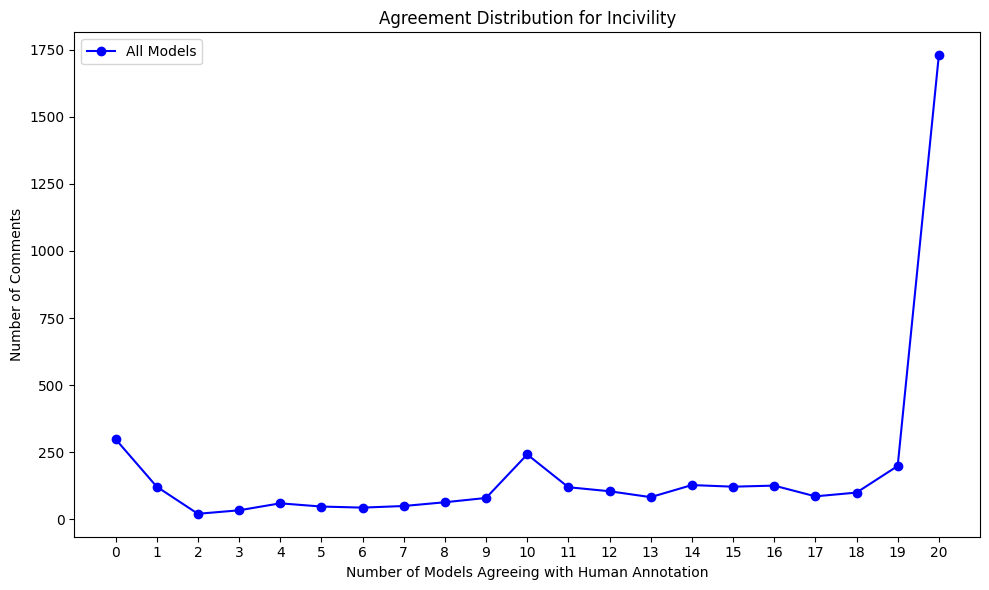

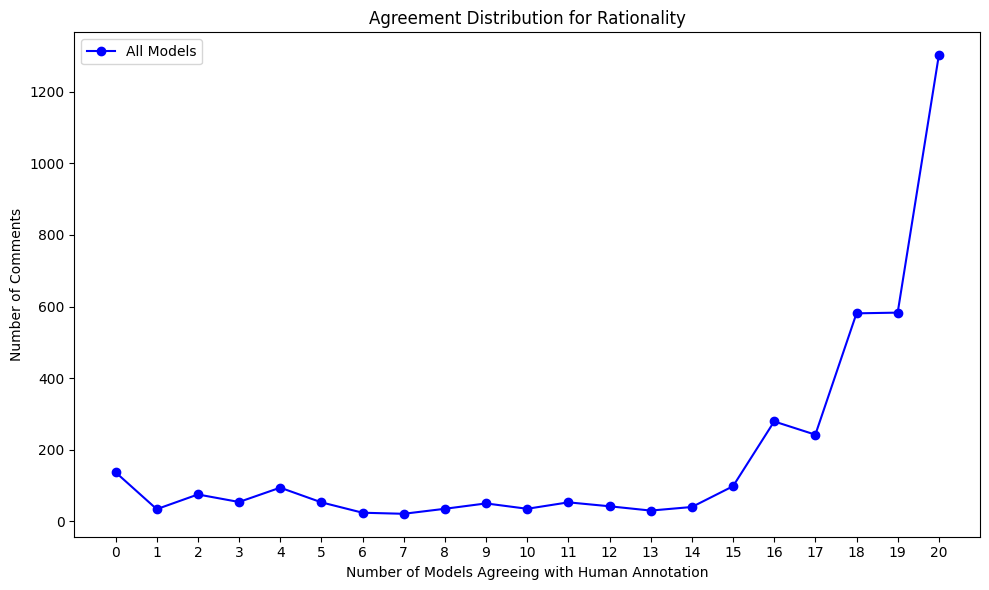

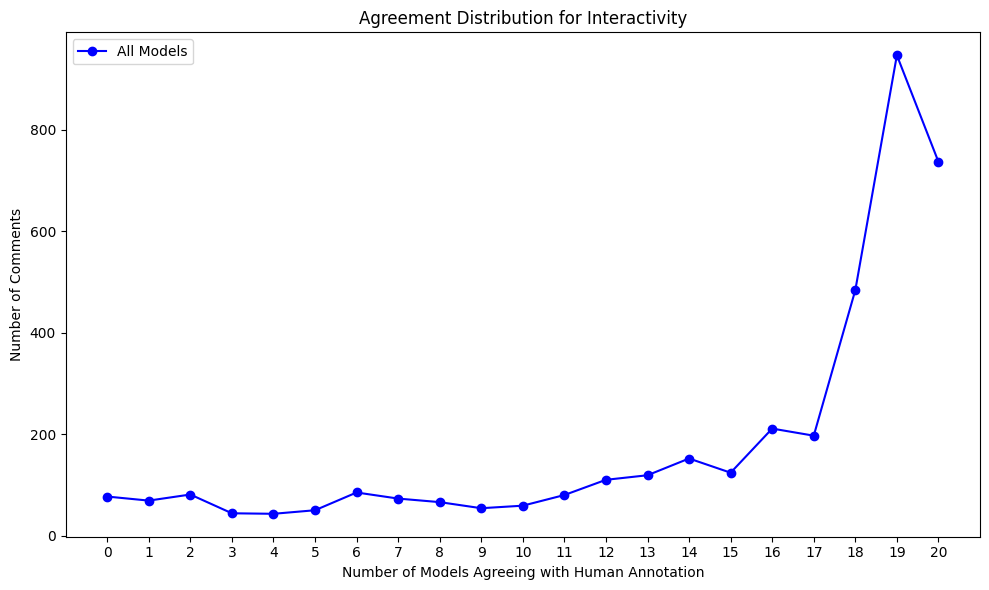

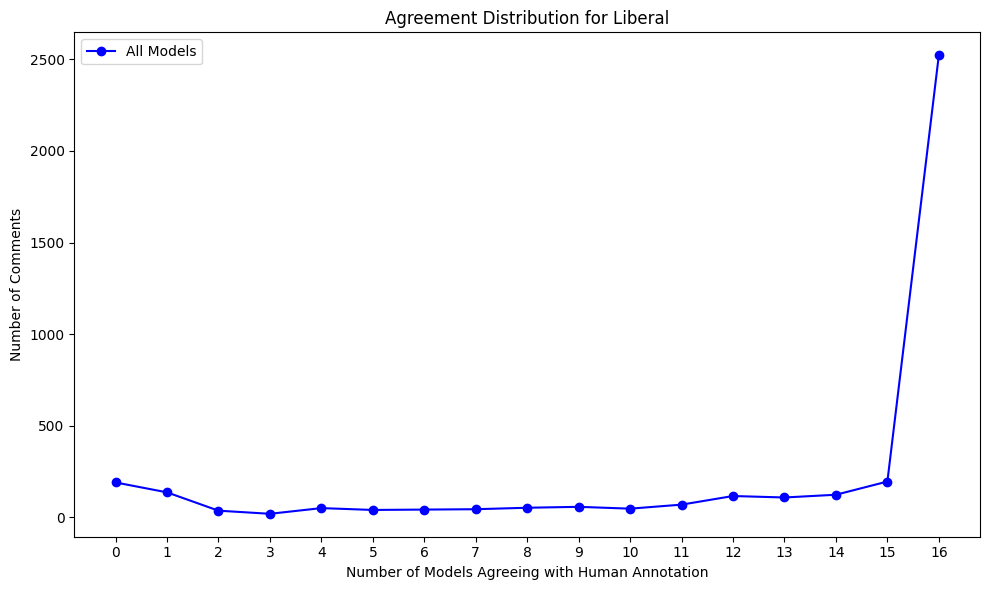

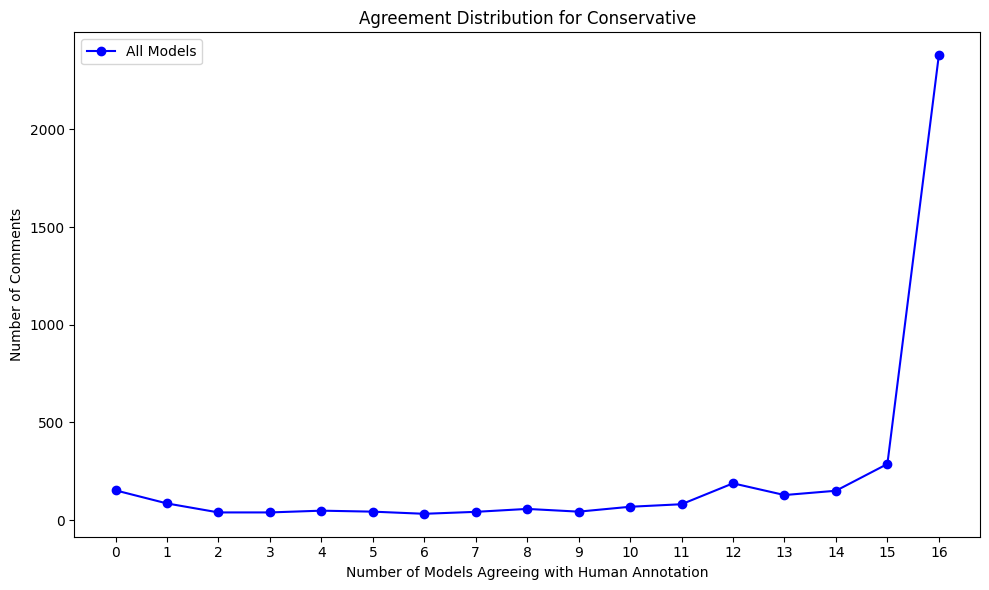

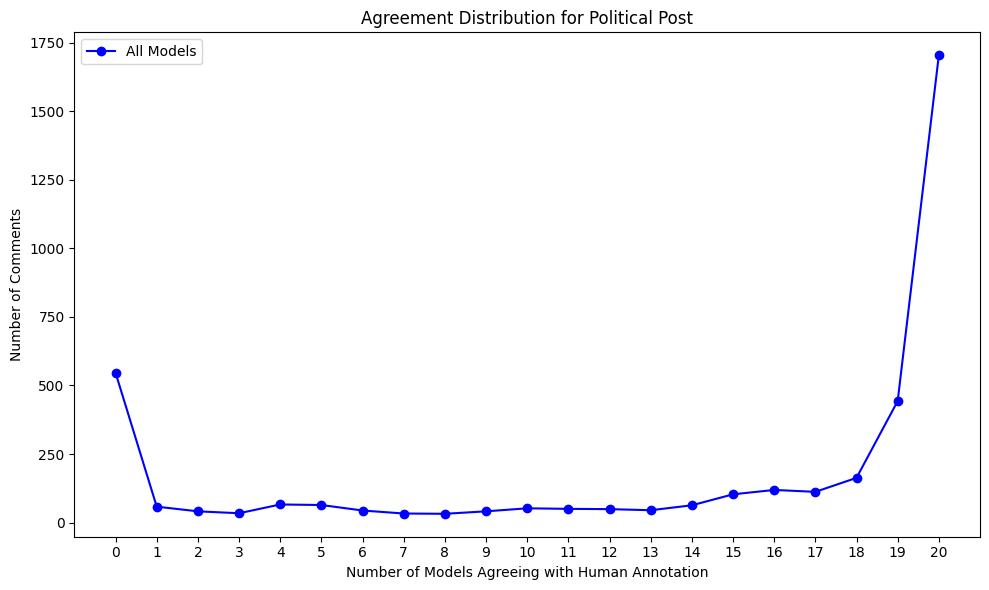

In [22]:

for concept, gt_col in concepts_info:
    concept_name = concept
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == concept_name]
    if not concept_model_cols or gt_col not in boukes.columns:
        continue

    # Calculate agreement matrix: shape (n_comments, n_models)
    agree_matrix = (boukes[concept_model_cols].values == boukes[gt_col].values[:, None])
    agree_counts = agree_matrix.sum(axis=1)  # total number of models agreeing per comment

    # Count number of comments for each possible number of models agreeing
    max_agree = len(concept_model_cols)
    x_vals = np.arange(0, max_agree + 1)
    comment_counts = np.array([(agree_counts == n).sum() for n in x_vals])

    # Plot line chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x_vals, comment_counts, marker='o', color='blue', label='All Models')

    ax.set_xticks(x_vals)
    ax.set_xlabel('Number of Models Agreeing with Human Annotation')
    ax.set_ylabel('Number of Comments')
    ax.set_title(f'Agreement Distribution for {concept_name}')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Comprehensive Agreement Analysis: Model vs Human Annotations

This section analyzes the agreement patterns between different models and human annotations across all concepts.

In [23]:
# Function to calculate agreement counts for each model vs human annotations
def calculate_agreement_stats(df, model_cols, gt_col):
    """
    Calculate agreement statistics between each model and ground truth
    Returns a dictionary with model names and their agreement counts
    """
    agreement_stats = {}
    
    for model_col in model_cols:
        # Skip if column doesn't exist
        if model_col not in df.columns or gt_col not in df.columns:
            continue
            
        # Get valid (non-null) observations for both columns
        valid_mask = df[model_col].notna() & df[gt_col].notna()
        if valid_mask.sum() == 0:
            continue
            
        model_pred = df.loc[valid_mask, model_col]
        human_truth = df.loc[valid_mask, gt_col]
        
        # Calculate agreements and disagreements
        agreements = (model_pred == human_truth).sum()
        disagreements = (model_pred != human_truth).sum()
        total = len(model_pred)
        
        # Get model info using the existing get_labels function
        model_info = get_labels(model_col)
        model_name = model_info['model']
        
        agreement_stats[model_col] = {
            'model_name': model_name,
            'agreements': agreements,
            'disagreements': disagreements,
            'total': total,
            'agreement_rate': agreements / total if total > 0 else 0
        }
    
    return agreement_stats

# Calculate agreement statistics for all concepts
all_agreement_stats = {}

# Use the same model selection as before
model_columns_for_analysis = model_columns_allprompts

# Define concepts and their ground truth columns
concepts_info_analysis = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

for concept_name, gt_col in concepts_info_analysis:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_for_analysis if get_labels(col)['concept'] == concept_name]
    
    if concept_model_cols and gt_col in boukes.columns:
        stats = calculate_agreement_stats(boukes, concept_model_cols, gt_col)
        all_agreement_stats[concept_name] = stats
        
        print(f"\n=== {concept_name} Agreement Statistics ===")
        for model_col, stat in stats.items():
            print(f"{stat['model_name']}: {stat['agreements']}/{stat['total']} agreements ({stat['agreement_rate']:.3f})")

print(f"\nProcessed {len(all_agreement_stats)} concepts")


=== Incivility Agreement Statistics ===
GPT4o: 2873/3862 agreements (0.744)
Qwen2.5:72b: 2833/3862 agreements (0.734)
Qwen2.5:72b: 2869/3862 agreements (0.743)
Qwen2.5:72b: 2810/3862 agreements (0.728)
Qwen2.5:72b: 2790/3862 agreements (0.722)
Qwen2.5:72b: 2824/3862 agreements (0.731)
Llama3.3:70b: 2844/3862 agreements (0.736)
Llama3.1:8b: 2709/3862 agreements (0.701)
GPT4o: 2707/3862 agreements (0.701)
GPT4o: 2768/3862 agreements (0.717)
GPT4o: 2837/3862 agreements (0.735)
GPT4o: 2800/3862 agreements (0.725)
Llama3.1:8b: 2689/3862 agreements (0.696)
Llama3.1:8b: 2672/3862 agreements (0.692)
Llama3.1:8b: 2766/3862 agreements (0.716)
Llama3.1:8b: 2748/3862 agreements (0.712)
Llama3.3:70b: 2818/3862 agreements (0.730)
Llama3.3:70b: 2861/3862 agreements (0.741)
Llama3.3:70b: 2848/3862 agreements (0.737)
Llama3.3:70b: 2866/3862 agreements (0.742)

=== Rationality Agreement Statistics ===
GPT4o: 3256/3862 agreements (0.843)
Qwen2.5:72b: 3265/3862 agreements (0.845)
Qwen2.5:72b: 2973/3862 a

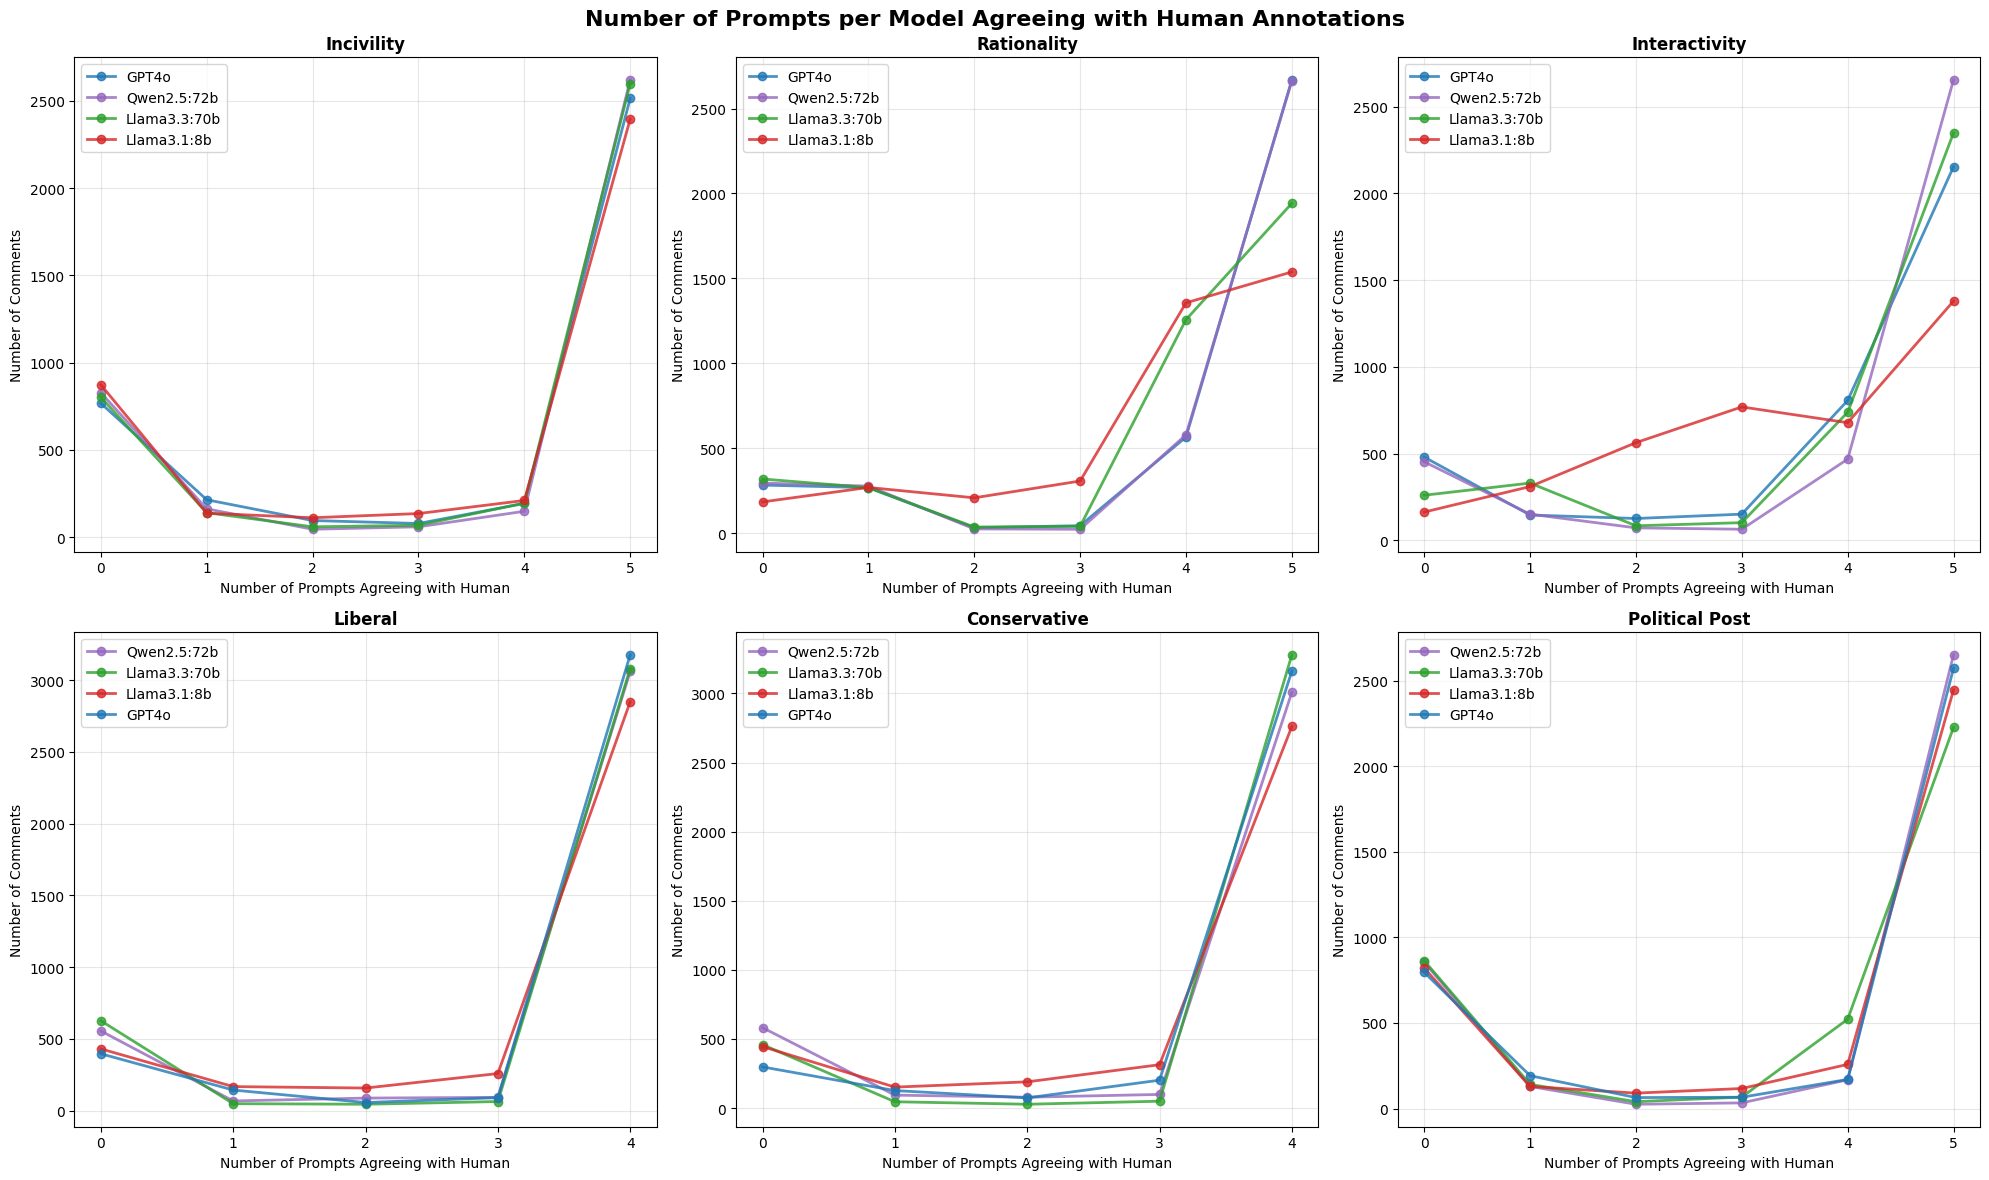


=== Prompt Agreement Summary ===

Incivility:
  GPT4o: Avg 3.62 prompts agree per comment (max: 5, total prompts: 5)
  Qwen2.5:72b: Avg 3.66 prompts agree per comment (max: 5, total prompts: 5)
  Llama3.3:70b: Avg 3.69 prompts agree per comment (max: 5, total prompts: 5)
  Llama3.1:8b: Avg 3.52 prompts agree per comment (max: 5, total prompts: 5)

Rationality:
  GPT4o: Avg 4.16 prompts agree per comment (max: 5, total prompts: 5)
  Qwen2.5:72b: Avg 4.15 prompts agree per comment (max: 5, total prompts: 5)
  Llama3.3:70b: Avg 3.94 prompts agree per comment (max: 5, total prompts: 5)
  Llama3.1:8b: Avg 3.81 prompts agree per comment (max: 5, total prompts: 5)

Interactivity:
  GPT4o: Avg 3.84 prompts agree per comment (max: 5, total prompts: 5)
  Qwen2.5:72b: Avg 4.05 prompts agree per comment (max: 5, total prompts: 5)
  Llama3.3:70b: Avg 4.01 prompts agree per comment (max: 5, total prompts: 5)
  Llama3.1:8b: Avg 3.46 prompts agree per comment (max: 5, total prompts: 5)

Liberal:
  Qw

In [27]:
# Count number of prompts (columns) per model that agree with human annotation
# Create line plots showing number of comments vs number of prompts agreeing

def count_prompt_agreements_per_comment(df, model_cols, gt_col):
    """
    For each comment, count how many prompts (columns) per model agree with human annotation
    Returns a dictionary with results for each model
    """
    model_prompt_counts = {}
    
    # Group columns by model
    model_groups = {}
    for col in model_cols:
        if col in df.columns:
            model_name = get_labels(col)['model']
            if model_name not in model_groups:
                model_groups[model_name] = []
            model_groups[model_name].append(col)
    
    # For each model, count agreements per comment
    for model_name, cols in model_groups.items():
        valid_mask = df[gt_col].notna()
        for col in cols:
            if col in df.columns:
                valid_mask &= df[col].notna()
        
        if valid_mask.sum() == 0:
            continue
            
        valid_df = df[valid_mask]
        comment_prompt_counts = []
        
        # For each comment, count how many prompts agree with human
        for idx, row in valid_df.iterrows():
            human_annotation = row[gt_col]
            agreements = 0
            
            for col in cols:
                if col in df.columns and row[col] == human_annotation:
                    agreements += 1
            
            comment_prompt_counts.append(agreements)
        
        model_prompt_counts[model_name] = comment_prompt_counts
    
    return model_prompt_counts

# Calculate prompt agreement counts for all concepts
all_prompt_counts = {}

for concept_name, gt_col in concepts_info_analysis:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_for_analysis if get_labels(col)['concept'] == concept_name]
    
    if concept_model_cols and gt_col in boukes.columns:
        prompt_counts = count_prompt_agreements_per_comment(boukes, concept_model_cols, gt_col)
        all_prompt_counts[concept_name] = prompt_counts

# Create line plots showing distribution of prompt agreements
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Number of Prompts per Model Agreeing with Human Annotations', fontsize=16, fontweight='bold')

# Define colors for different models to ensure consistent visualization
model_colors = {
    'GPT4o': '#1f77b4',        # Blue
    'GPT4T': '#ff7f0e',        # Orange  
    'Llama3.3:70b': '#2ca02c',  # Green
    'Llama3.1:8b': '#d62728',   # Red
    'Qwen2.5:72b': '#9467bd'    # Purple
}

for i, (concept_name, gt_col) in enumerate(concepts_info_analysis):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    if concept_name in all_prompt_counts:
        prompt_data = all_prompt_counts[concept_name]
        
        for model_name, counts in prompt_data.items():
            if counts:  # Only plot if we have data
                # Count frequency of each number of agreeing prompts
                unique_counts, frequencies = np.unique(counts, return_counts=True)
                
                # Create line plot
                ax.plot(unique_counts, frequencies, 
                       marker='o', linewidth=2, markersize=6,
                       color=model_colors.get(model_name, '#gray'),
                       label=model_name, alpha=0.8)
        
        # Customize the plot
        ax.set_title(f'{concept_name}', fontweight='bold')
        ax.set_xlabel('Number of Prompts Agreeing with Human')
        ax.set_ylabel('Number of Comments')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Set integer ticks on x-axis
        if concept_name in all_prompt_counts and all_prompt_counts[concept_name]:
            max_prompts = max([max(counts) if counts else 0 for counts in all_prompt_counts[concept_name].values()])
            ax.set_xticks(range(0, max_prompts + 1))
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{concept_name}', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics for prompt agreement counts
print("\n=== Prompt Agreement Summary ===")
for concept_name, prompt_data in all_prompt_counts.items():
    print(f"\n{concept_name}:")
    for model_name, counts in prompt_data.items():
        if counts:
            avg_agreements = np.mean(counts)
            max_agreements = max(counts)
            total_prompts = len([col for col in model_columns_for_analysis 
                               if get_labels(col)['concept'] == concept_name and 
                               get_labels(col)['model'] == model_name])
            print(f"  {model_name}: Avg {avg_agreements:.2f} prompts agree per comment (max: {max_agreements}, total prompts: {total_prompts})")

# Create summary table showing distribution percentages
print("\n=== Distribution of Prompt Agreement Counts (%) ===")
for concept_name, prompt_data in all_prompt_counts.items():
    print(f"\n{concept_name}:")
    for model_name, counts in prompt_data.items():
        if counts:
            unique_counts, frequencies = np.unique(counts, return_counts=True)
            total_comments = sum(frequencies)
            print(f"  {model_name}:")
            for count, freq in zip(unique_counts, frequencies):
                percentage = (freq / total_comments) * 100
                print(f"    {count} prompts agree: {freq} comments ({percentage:.1f}%)")

In [ ]:
#don't see a large effect of prompt on the number of agreeing comments, but there is a large variance in the number of agreeing comments per model, 
# except for L31:8b for interactivity 
#and both llama models for rationality

In [73]:
# Analyze identical annotations between models and their agreement with human annotations
def analyze_model_consensus_accuracy(df, model_cols, gt_col):
    """
    Analyze when models agree with each other and how often those agreements match human annotations
    """
    results = {
        'identical_positive_correct': 0,  # All models predict positive, and human is positive
        'identical_negative_correct': 0,  # All models predict negative, and human is negative
        'identical_positive_incorrect': 0,  # All models predict positive, but human is negative
        'identical_negative_incorrect': 0,  # All models predict negative, but human is positive
        'partial_consensus': 0,  # Some models agree but not all
        'total_observations': 0
    }
    
    if len(model_cols) < 2 or gt_col not in df.columns:
        return results
    
    # Get valid observations where all models and ground truth have data
    valid_mask = df[gt_col].notna()
    for col in model_cols:
        if col in df.columns:
            valid_mask &= df[col].notna()
    
    if valid_mask.sum() == 0:
        return results
    
    valid_df = df[valid_mask]
    results['total_observations'] = len(valid_df)
    
    for idx, row in valid_df.iterrows():
        human_annotation = row[gt_col]
        model_predictions = [row[col] for col in model_cols if col in df.columns]
        
        # Check if all models agree
        if len(set(model_predictions)) == 1:  # All models have identical predictions
            model_prediction = model_predictions[0]
            
            if model_prediction == 1 and human_annotation == 1:
                results['identical_positive_correct'] += 1
            elif model_prediction == 0 and human_annotation == 0:
                results['identical_negative_correct'] += 1
            elif model_prediction == 1 and human_annotation == 0:
                results['identical_positive_incorrect'] += 1
            elif model_prediction == 0 and human_annotation == 1:
                results['identical_negative_incorrect'] += 1
        else:
            results['partial_consensus'] += 1
    
    return results

# Calculate consensus accuracy for each concept
consensus_results = {}
consensus_summary_data = []

print("=== Model Consensus vs Human Annotation Analysis ===")

for concept_name, gt_col in concepts_info_analysis:
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_for_analysis if get_labels(col)['concept'] == concept_name]
    
    if len(concept_model_cols) >= 2 and gt_col in boukes.columns:
        results = analyze_model_consensus_accuracy(boukes, concept_model_cols, gt_col)
        consensus_results[concept_name] = results
        
        total = results['total_observations']
        if total > 0:
            # Calculate percentages
            identical_correct = results['identical_positive_correct'] + results['identical_negative_correct']
            identical_incorrect = results['identical_positive_incorrect'] + results['identical_negative_incorrect']
            
            print(f"\n--- {concept_name} ---")
            print(f"Total observations: {total}")
            print(f"Models all agree and correct: {identical_correct} ({identical_correct/total*100:.1f}%)")
            print(f"  - All positive & human positive: {results['identical_positive_correct']} ({results['identical_positive_correct']/total*100:.1f}%)")
            print(f"  - All negative & human negative: {results['identical_negative_correct']} ({results['identical_negative_correct']/total*100:.1f}%)")
            print(f"Models all agree but incorrect: {identical_incorrect} ({identical_incorrect/total*100:.1f}%)")
            print(f"  - All positive but human negative: {results['identical_positive_incorrect']} ({results['identical_positive_incorrect']/total*100:.1f}%)")
            print(f"  - All negative but human positive: {results['identical_negative_incorrect']} ({results['identical_negative_incorrect']/total*100:.1f}%)")
            print(f"Models disagree: {results['partial_consensus']} ({results['partial_consensus']/total*100:.1f}%)")
            
            # Store for visualization
            consensus_summary_data.append({
                'Concept': concept_name,
                'Total_Observations': total,
                'Identical_Correct': identical_correct,
                'Identical_Incorrect': identical_incorrect,
                'Partial_Consensus': results['partial_consensus'],
                'Identical_Correct_Pct': identical_correct/total*100,
                'Identical_Incorrect_Pct': identical_incorrect/total*100,
                'Partial_Consensus_Pct': results['partial_consensus']/total*100,
                'Pos_Correct': results['identical_positive_correct'],
                'Neg_Correct': results['identical_negative_correct'],
                'Pos_Incorrect': results['identical_positive_incorrect'],
                'Neg_Incorrect': results['identical_negative_incorrect']
            })

# Create DataFrame for easier manipulation
consensus_df = pd.DataFrame(consensus_summary_data)
print(f"\nProcessed {len(consensus_df)} concepts for consensus analysis")

=== Model Consensus vs Human Annotation Analysis ===

--- Incivility ---
Total observations: 3862
Models all agree and correct: 1729 (44.8%)
  - All positive & human positive: 570 (14.8%)
  - All negative & human negative: 1159 (30.0%)
Models all agree but incorrect: 299 (7.7%)
  - All positive but human negative: 39 (1.0%)
  - All negative but human positive: 260 (6.7%)
Models disagree: 1834 (47.5%)

--- Rationality ---
Total observations: 3862
Models all agree and correct: 1302 (33.7%)
  - All positive & human positive: 37 (1.0%)
  - All negative & human negative: 1265 (32.8%)
Models all agree but incorrect: 137 (3.5%)
  - All positive but human negative: 10 (0.3%)
  - All negative but human positive: 127 (3.3%)
Models disagree: 2423 (62.7%)

--- Interactivity ---
Total observations: 3862
Models all agree and correct: 737 (19.1%)
  - All positive & human positive: 2 (0.1%)
  - All negative & human negative: 735 (19.0%)
Models all agree but incorrect: 77 (2.0%)
  - All positive but hu

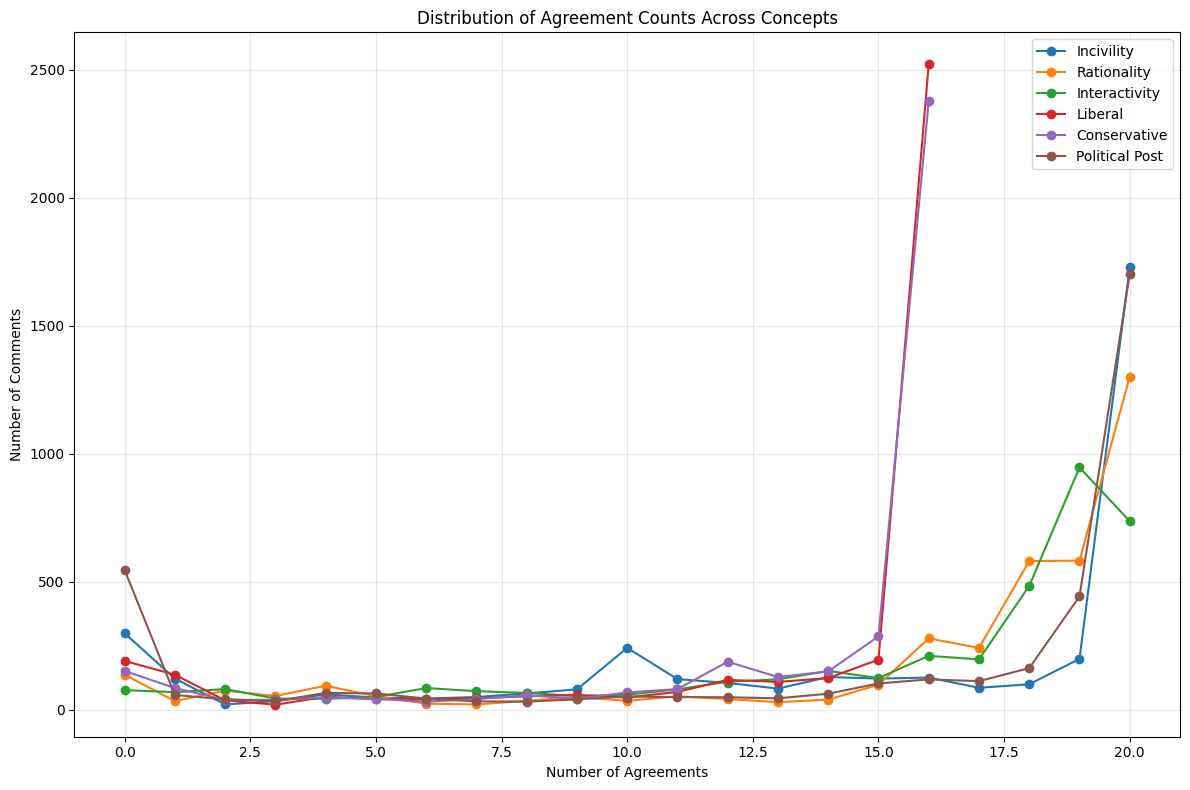

In [29]:
#use get_labels to get the model names and concepts for each column in all_model_prompts
model_labels = [get_labels(col) for col in model_columns_allprompts]

#make an agreement matrix that shows the agreement per row for each model column with the relevant ground truth column
def create_agreement_matrix(df, model_cols, gt_col):    
    """
    Create an agreement matrix showing how each model column agrees with the ground truth column
    Returns a DataFrame with models as columns and comments as rows
    """
    if gt_col not in df.columns or len(model_cols) == 0:
        return pd.DataFrame()
    
    # Initialize the agreement matrix
    agreement_matrix = pd.DataFrame(index=df.index, columns=model_cols)
    
    # Fill the matrix with agreement values (1 for agree, 0 for disagree)
    for col in model_cols:
        if col in df.columns:
            agreement_matrix[col] = (df[col] == df[gt_col]).astype(int)
    
    return agreement_matrix

# Create agreement matrix for all models and concepts
agreement_matrix_all = {}
posagreement_matrix_all = {}
negagreement_matrix_all = {}
for concept_name, _ in concepts_info:
    gt_col = get_ground_truth_col(concept_name)
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == concept_name]
    if concept_model_cols and gt_col in boukes.columns:
        agreement_matrix = create_agreement_matrix(boukes, concept_model_cols, gt_col)
        agreement_matrix_all[concept_name] = agreement_matrix
        # Create agreement matrices for positive and negative annotations using the ground truth column from boukes
        pos_idx = boukes[gt_col] == 1
        neg_idx = boukes[gt_col] == 0
        posagreement_matrix_all[concept_name] = agreement_matrix[pos_idx]
        negagreement_matrix_all[concept_name] = agreement_matrix[neg_idx]

#now use this posagreement_matrix_all and negagreement_matrix_all to calculate the number of annotation columns per model that agree and that disagree with the human annotations for each comment
def count_agreements_per_comment(agreement_matrix):
    """
    Count the number of positive and negative agreements for each comment in the agreement matrix
    Returns a DataFrame with counts of positive and negative agreements per comment
    """
    if agreement_matrix.empty:
        return pd.DataFrame(columns=['Positive Agreements', 'Negative Agreements'])
    
    # Count positive agreements (1s) and negative agreements (0s)
    agreements = agreement_matrix.sum(axis=1)

    #store the counts in a DataFrame
    agreements = pd.DataFrame({
        'Total Agreements': agreements,
    })
    return agreements

def count_positive_agreements_per_comment(posagreement_matrix_all):
    """
    Count the number of positive agreements for each comment in the agreement matrix
    Returns a DataFrame with counts of positive agreements per comment
    """
    if agreement_matrix.empty:
        return pd.DataFrame(columns=['Positive Agreements'])
    
    # Count positive agreements (1s)
    pos_agreements = posagreement_matrix_all.sum(axis=1)
    
    # Create a DataFrame with the counts
    poscountsdf = pd.DataFrame({
        'Positive Agreements': pos_agreements
    })
    
    return poscountsdf

def count_negative_agreements_per_comment(negagreement_matrix_all):
    """
    Count the number of negative agreements for each comment in the agreement matrix
    Returns a DataFrame with counts of negative agreements per comment
    """
    if agreement_matrix.empty:
        return pd.DataFrame(columns=['Negative Agreements'])
    
    # Count negative agreements (0s)
    neg_agreements = negagreement_matrix_all.sum(axis=1)
    
    # Create a DataFrame with the counts
    negcountsdf = pd.DataFrame({
        'Negative Agreements': neg_agreements
    })
    
    return negcountsdf


# Count agreements for each concept
agreement_counts_all = {}
for concept_name, _ in concepts_info:
    gt_col = get_ground_truth_col(concept_name)
    # Filter model columns for this concept
    concept_model_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == concept_name]
    if concept_model_cols and gt_col in boukes.columns:
        agreement_matrix = create_agreement_matrix(boukes, concept_model_cols, gt_col)
        posagreement_matrix = posagreement_matrix_all.get(concept_name, pd.DataFrame())
        negagreement_matrix = negagreement_matrix_all.get(concept_name, pd.DataFrame())
        
        # Count agreements
        counts_df = count_agreements_per_comment(agreement_matrix)
        pos_counts_df = count_positive_agreements_per_comment(posagreement_matrix)
        neg_counts_df = count_negative_agreements_per_comment(negagreement_matrix)
        
        # Combine counts into a single DataFrame
        combined_counts = pd.concat([counts_df, pos_counts_df, neg_counts_df], axis=1)
        
        # Store the counts for this concept
        agreement_counts_all[concept_name] = combined_counts

#now make a line plot showing the distribution of the number of agreeing comments per model, split out across concepts  
def plot_agreement_distribution(agreement_counts_all):
    """
    Plot the distribution of agreement counts for each concept
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for concept_name, counts_df in agreement_counts_all.items():
        if counts_df.empty:
            continue
        
        # Count frequency of each number of agreements
        unique_counts, frequencies = np.unique(counts_df['Total Agreements'], return_counts=True)
        
        # Create line plot
        ax.plot(unique_counts, frequencies, marker='o', label=concept_name)
    
    ax.set_title('Distribution of Agreement Counts Across Concepts')
    ax.set_xlabel('Number of Agreements')
    ax.set_ylabel('Number of Comments')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the agreement distribution for all concepts
plot_agreement_distribution(agreement_counts_all)





In [ ]:
#number of annotation columns (5 prompts x 4 models, except for ideology -> 4 prompts x 4 models) that agree with the human annotations for each comment, split out across concepts


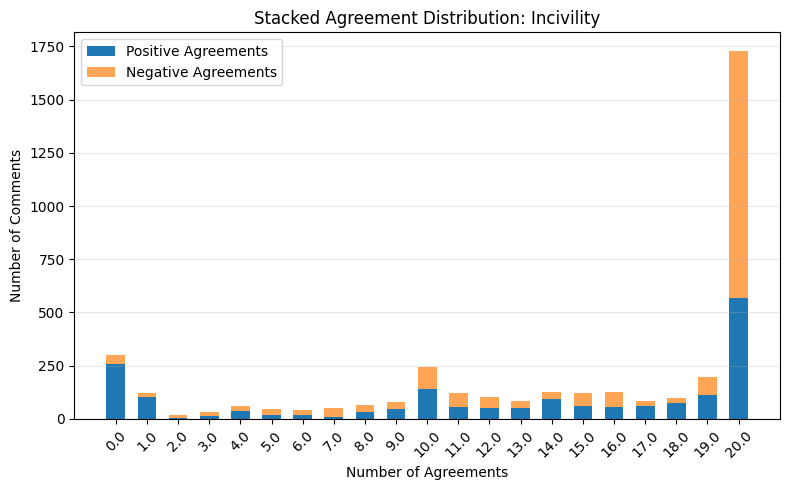

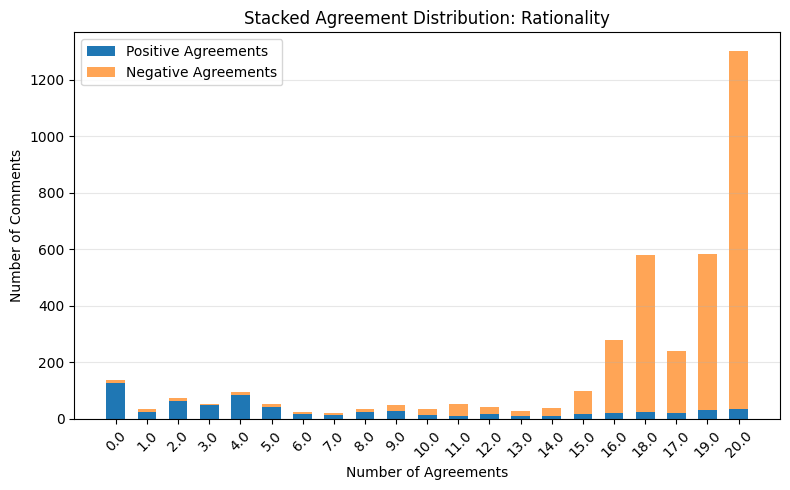

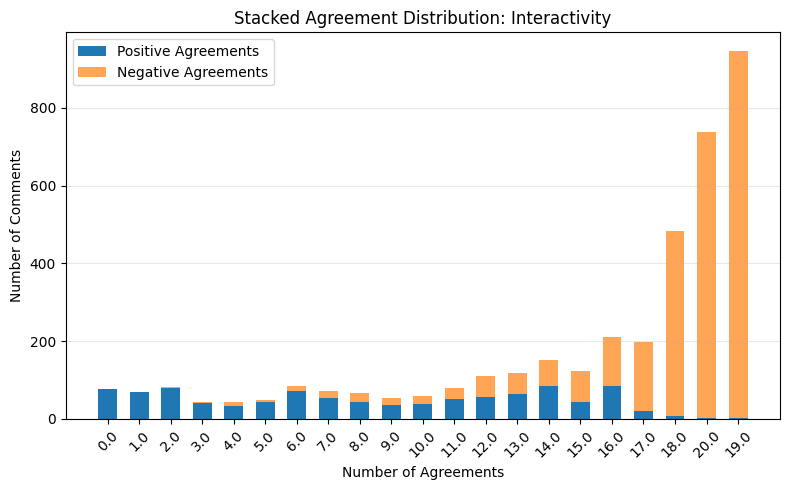

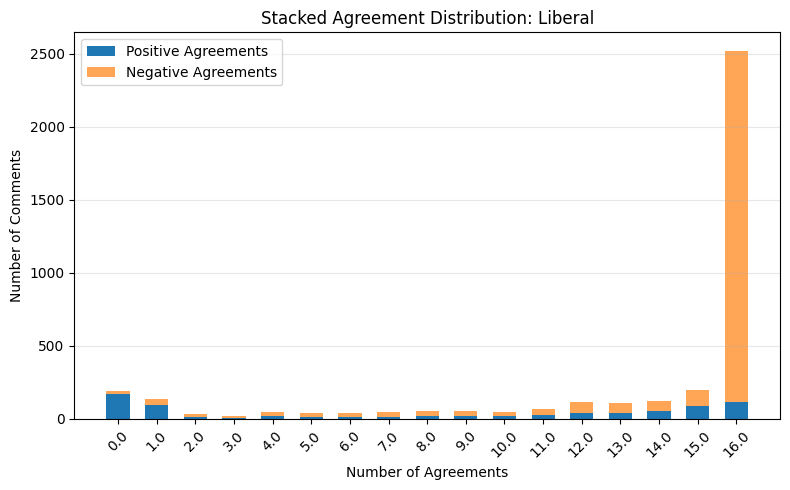

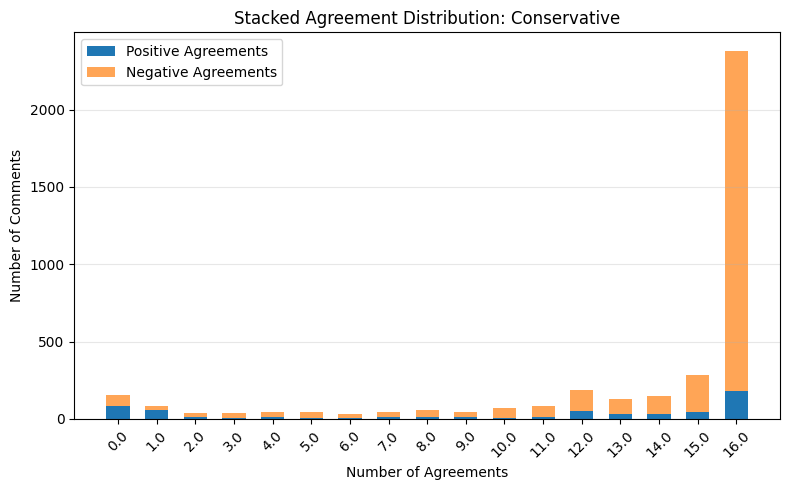

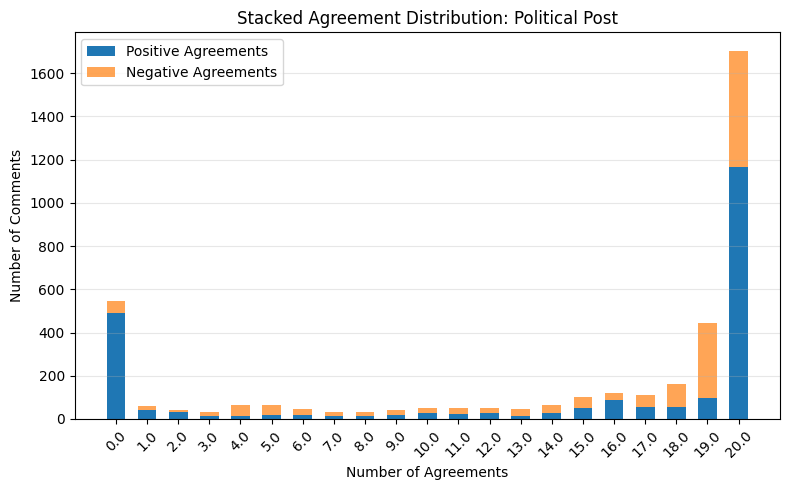

In [30]:
def plot_stacked_agreement_per_concept(agreement_counts_all):
    """
    For each concept, plot a stacked bar chart showing the number of comments
    with each possible number of positive and negative agreements.
    Each concept gets its own plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    for concept_name, counts_df in agreement_counts_all.items():
        if counts_df.empty:
            continue

        # Only keep agreement counts that actually occur
        all_counts = sorted(set(counts_df['Positive Agreements']).union(counts_df['Negative Agreements']))
        pos_counts = counts_df['Positive Agreements'].value_counts().sort_index()
        neg_counts = counts_df['Negative Agreements'].value_counts().sort_index()
        # Only keep counts where at least one is nonzero
        valid_counts = [c for c in all_counts if pos_counts.get(c, 0) > 0 or neg_counts.get(c, 0) > 0]
        pos_vals = [pos_counts.get(c, 0) for c in valid_counts]
        neg_vals = [neg_counts.get(c, 0) for c in valid_counts]

        x = np.arange(len(valid_counts))
        width = 0.6

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.bar(x, pos_vals, width, label='Positive Agreements', color='tab:blue')
        ax.bar(x, neg_vals, width, bottom=pos_vals, label='Negative Agreements', color='tab:orange', alpha=0.7)

        ax.set_xticks(x)
        ax.set_xticklabels(valid_counts, rotation=45)
        ax.set_xlabel('Number of Agreements')
        ax.set_ylabel('Number of Comments')
        ax.set_title(f'Stacked Agreement Distribution: {concept_name}')
        ax.legend()
        ax.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Plot stacked agreement distributions for each concept
plot_stacked_agreement_per_concept(agreement_counts_all)

In [ ]:
#the agreement distribution shows that agreement is mostly based on the negative class -> models agree what is not incivil, rational, interactive etc.
#there is more disagreement on the positive class, with more spread in the number of positive agreements per comment, except for political post


## Venn Diagram Analysis for All Concepts

Now let's extend the Venn diagram analysis to all concepts to understand overlap patterns across different discourse dimensions.

In [ ]:
#use boukes_concepts_info to find gt columns for each concept
def get_ground_truth_col(concept_name):
    """
    Get the ground truth column name for a given concept.
    """
    for concept, gt_col in boukes_concepts_info:
        if concept == concept_name:
            return gt_col
    return None

Running model comparison analysis...
Using existing notebook variables: boukes dataset, boukes_concepts_info, model_columns_zero_boukes


Analyzing concept: Incivility
Available models: ['GPT4o', 'Llama3.1:8b', 'GPT4T', 'Llama3.3:70b', 'Qwen2.5:72b']
Number of model columns: 5

MODEL COMPARISON: INCIVILITY (Zero Temperature Boukes Prompts)

Model ranking (by Jaccard score):
--------------------------------------------------------------------------------
 1. GPT4T          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.603, F1: 0.753
 2. Llama3.3:70b   : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.589, F1: 0.742
 3. Qwen2.5:72b    : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.584, F1: 0.738
 4. GPT4o          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.521, F1: 0.685
 5. Llama3.1:8b    : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.428, F1: 0.599


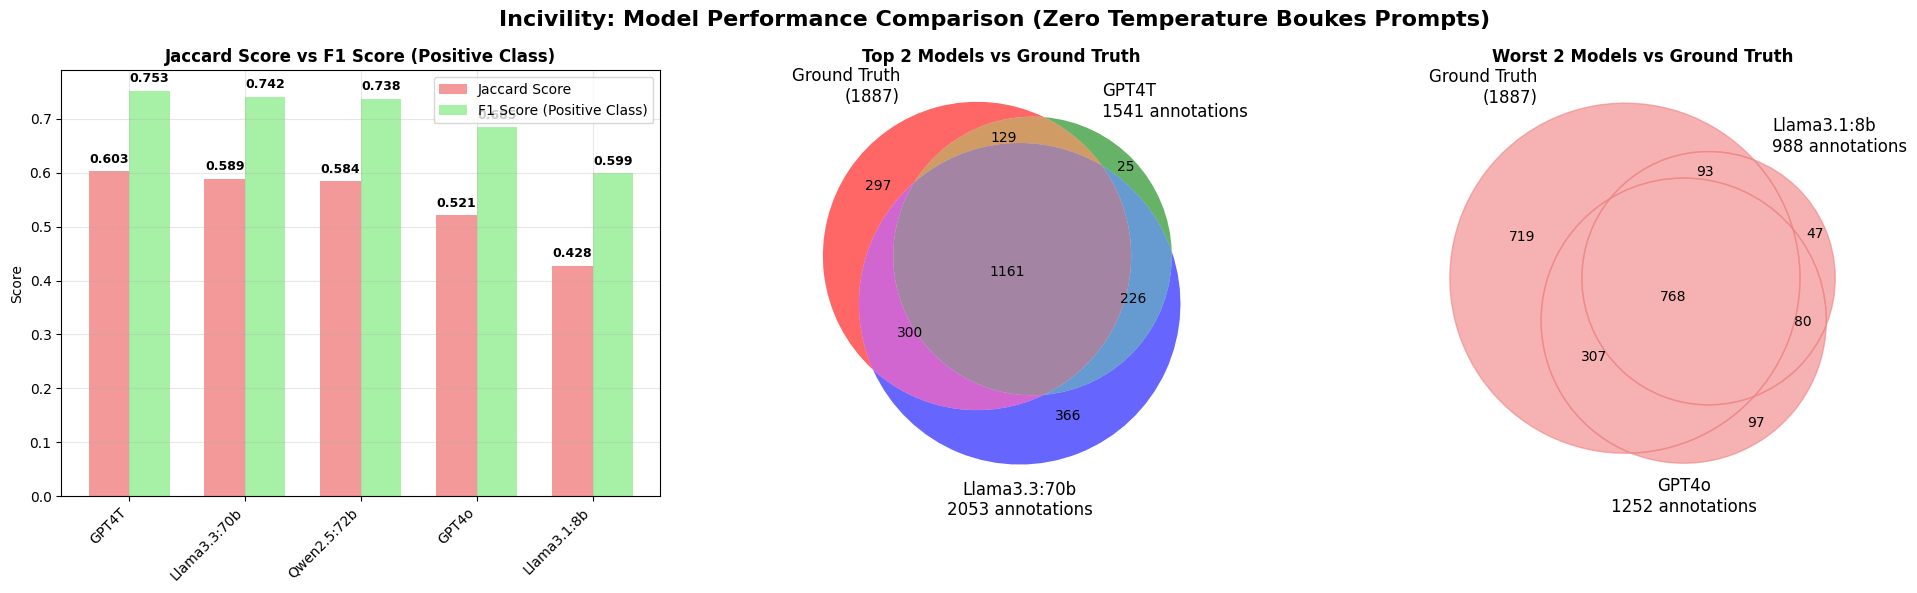


--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Jaccard Score Statistics:
  Mean: 0.545
  Std:  0.065
  Min:  0.428 (Llama3.1:8b)
  Max:  0.603 (GPT4T)

F1 Score (Positive Class) Statistics:
  Mean: 0.703
  Std:  0.057
  Min:  0.599 (Llama3.1:8b)
  Max:  0.753 (GPT4T)


Analyzing concept: Rationality
Available models: ['GPT4o', 'Llama3.1:8b', 'GPT4T', 'Llama3.3:70b', 'Qwen2.5:72b']
Number of model columns: 5

MODEL COMPARISON: RATIONALITY (Zero Temperature Boukes Prompts)

Model ranking (by Jaccard score):
--------------------------------------------------------------------------------
 1. Llama3.3:70b   : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.318, F1: 0.483
 2. Qwen2.5:72b    : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.205, F1: 0.340
 3. GPT4o          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.171, F1: 0.292
 4. Llama3.1:8b    : Boukes     (Temp: 

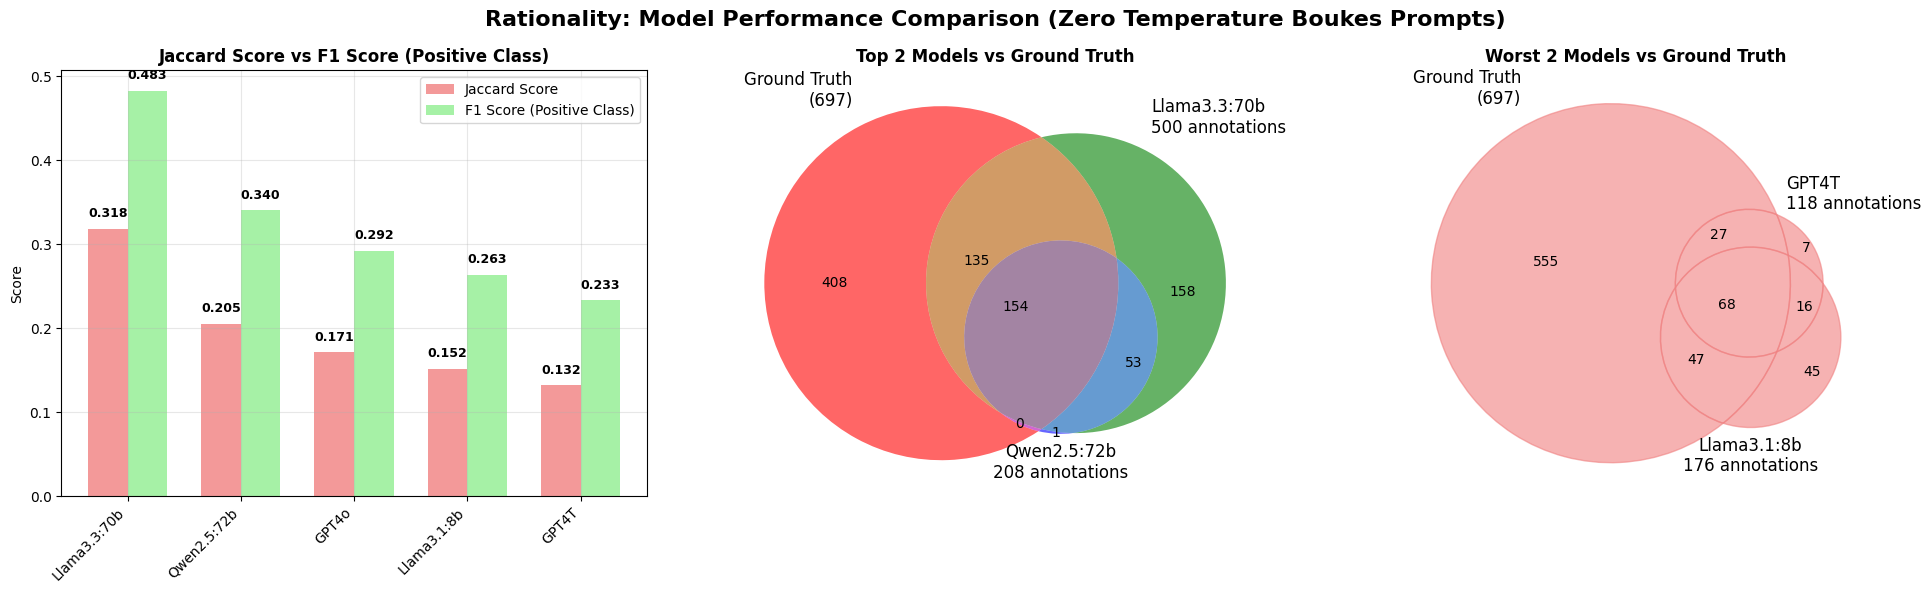


--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Jaccard Score Statistics:
  Mean: 0.196
  Std:  0.066
  Min:  0.132 (GPT4T)
  Max:  0.318 (Llama3.3:70b)

F1 Score (Positive Class) Statistics:
  Mean: 0.322
  Std:  0.088
  Min:  0.233 (GPT4T)
  Max:  0.483 (Llama3.3:70b)


Analyzing concept: Interactivity
Available models: ['GPT4o', 'Llama3.1:8b', 'GPT4T', 'Llama3.3:70b', 'Qwen2.5:72b']
Number of model columns: 5

MODEL COMPARISON: INTERACTIVITY (Zero Temperature Boukes Prompts)

Model ranking (by Jaccard score):
--------------------------------------------------------------------------------
 1. Llama3.3:70b   : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.500, F1: 0.667
 2. Qwen2.5:72b    : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.420, F1: 0.592
 3. GPT4T          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.334, F1: 0.500
 4. GPT4o          : Boukes     (

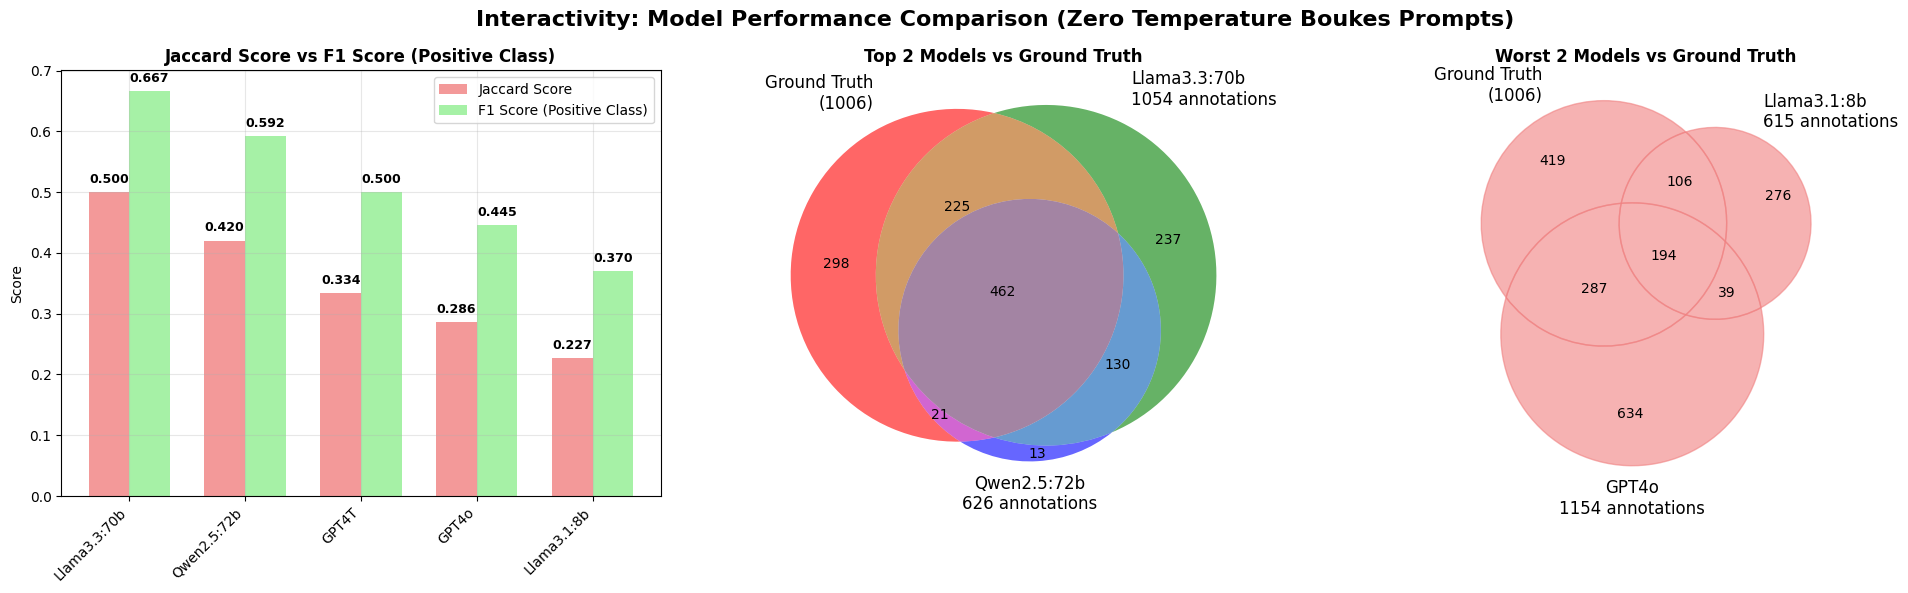


--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Jaccard Score Statistics:
  Mean: 0.354
  Std:  0.097
  Min:  0.227 (Llama3.1:8b)
  Max:  0.500 (Llama3.3:70b)

F1 Score (Positive Class) Statistics:
  Mean: 0.515
  Std:  0.105
  Min:  0.370 (Llama3.1:8b)
  Max:  0.667 (Llama3.3:70b)


Analyzing concept: Liberal
Available models: ['GPT4o', 'Llama3.1:8b', 'GPT4T', 'Llama3.3:70b', 'Qwen2.5:72b']
Number of model columns: 5

MODEL COMPARISON: LIBERAL (Zero Temperature Boukes Prompts)

Model ranking (by Jaccard score):
--------------------------------------------------------------------------------
 1. GPT4o          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.501, F1: 0.667
 2. GPT4T          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.483, F1: 0.652
 3. Llama3.3:70b   : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.412, F1: 0.584
 4. Qwen2.5:72b    : Boukes     (

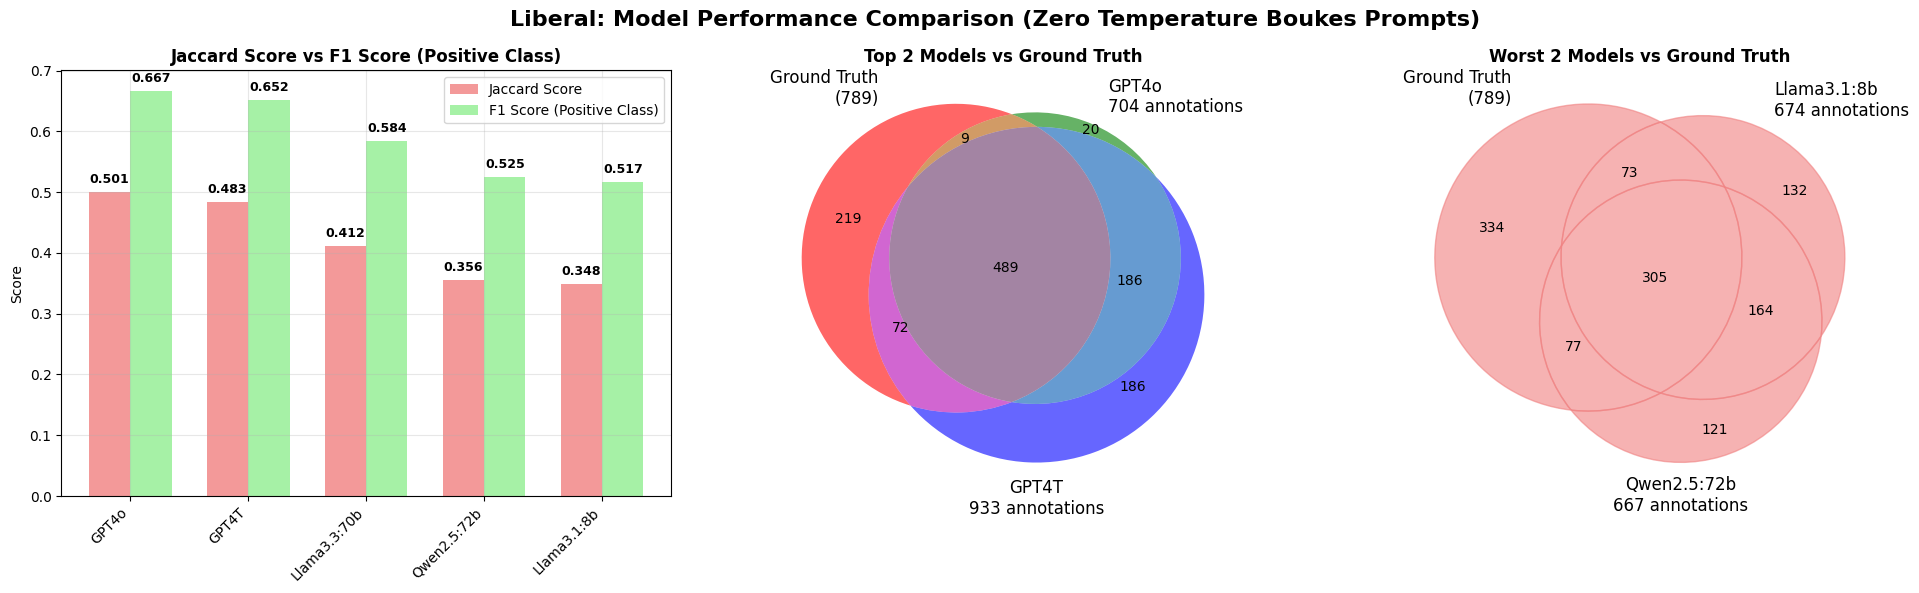


--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Jaccard Score Statistics:
  Mean: 0.420
  Std:  0.063
  Min:  0.348 (Llama3.1:8b)
  Max:  0.501 (GPT4o)

F1 Score (Positive Class) Statistics:
  Mean: 0.589
  Std:  0.062
  Min:  0.517 (Llama3.1:8b)
  Max:  0.667 (GPT4o)


Analyzing concept: Conservative
Available models: ['GPT4o', 'Llama3.1:8b', 'GPT4T', 'Llama3.3:70b', 'Qwen2.5:72b']
Number of model columns: 5

MODEL COMPARISON: CONSERVATIVE (Zero Temperature Boukes Prompts)

Model ranking (by Jaccard score):
--------------------------------------------------------------------------------
 1. GPT4o          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.502, F1: 0.669
 2. GPT4T          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.464, F1: 0.634
 3. Llama3.3:70b   : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.427, F1: 0.598
 4. Qwen2.5:72b    : Boukes     (Temp

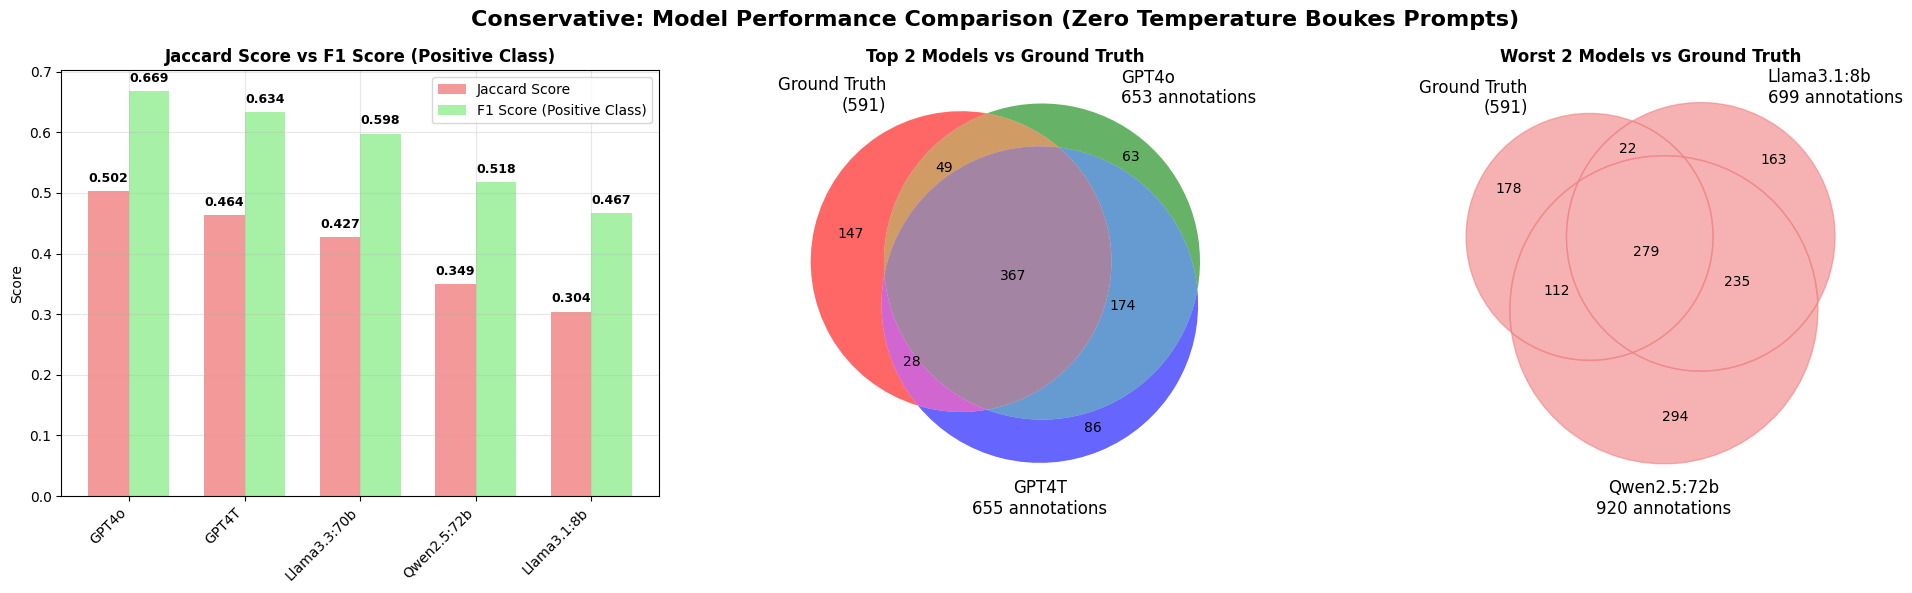


--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Jaccard Score Statistics:
  Mean: 0.409
  Std:  0.073
  Min:  0.304 (Llama3.1:8b)
  Max:  0.502 (GPT4o)

F1 Score (Positive Class) Statistics:
  Mean: 0.577
  Std:  0.075
  Min:  0.467 (Llama3.1:8b)
  Max:  0.669 (GPT4o)


Analyzing concept: Political Post
Available models: ['GPT4o', 'Llama3.1:8b', 'GPT4T', 'Llama3.3:70b', 'Qwen2.5:72b']
Number of model columns: 5

MODEL COMPARISON: POLITICAL POST (Zero Temperature Boukes Prompts)

Model ranking (by Jaccard score):
--------------------------------------------------------------------------------
 1. Llama3.3:70b   : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.615, F1: 0.762
 2. Qwen2.5:72b    : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.612, F1: 0.759
 3. GPT4T          : Boukes     (Temp: Zero: 0.0) - Jaccard: 0.598, F1: 0.749
 4. Llama3.1:8b    : Boukes     (

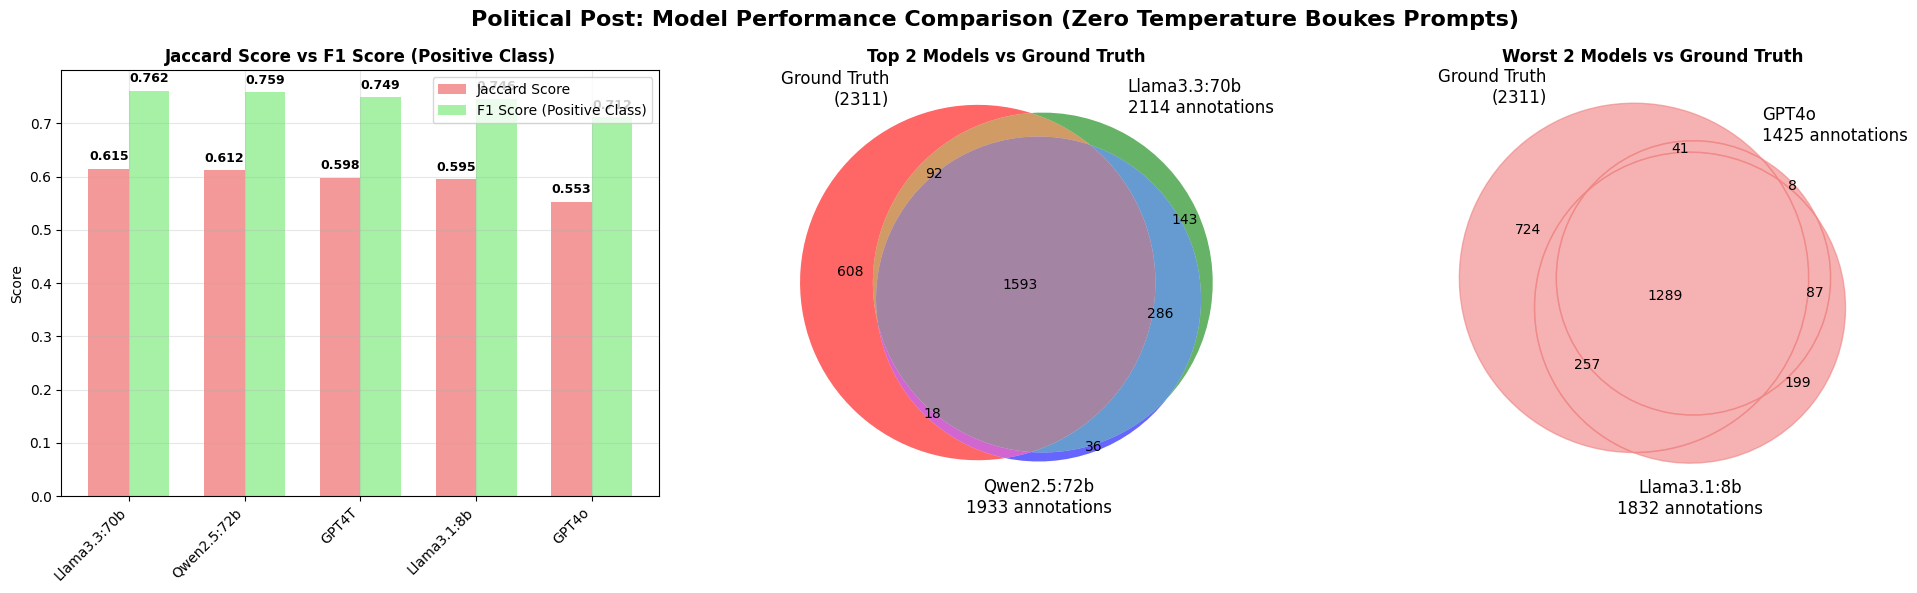


--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Jaccard Score Statistics:
  Mean: 0.595
  Std:  0.022
  Min:  0.553 (GPT4o)
  Max:  0.615 (Llama3.3:70b)

F1 Score (Positive Class) Statistics:
  Mean: 0.746
  Std:  0.018
  Min:  0.712 (GPT4o)
  Max:  0.762 (Llama3.3:70b)

CROSS-CONCEPT SUMMARY: MODEL PERFORMANCE

Top performing model per concept:
--------------------------------------------------------------------------------
Incivility     : GPT4T        - Jaccard: 0.603, F1: 0.753
Rationality    : Llama3.3:70b - Jaccard: 0.318, F1: 0.483
Interactivity  : Llama3.3:70b - Jaccard: 0.500, F1: 0.667
Liberal        : GPT4o        - Jaccard: 0.501, F1: 0.667
Conservative   : GPT4o        - Jaccard: 0.502, F1: 0.669
Political Post : Llama3.3:70b - Jaccard: 0.615, F1: 0.762

Overall model performance (average scores across concepts):
----------------------------

In [38]:
columnset = model_columns_zero_boukes  # model_columns_zero_boukes, model_columns_alltemps, model_columns_allprompts


def compare_models_zero_temperature(concept_name, gt_col, model_cols, dataset):
    """
    Compare models using zero temperature Boukes prompts only.
    Simplified version without best prompt selection since we only use zero temperature Boukes prompts.
    """
    print(f"\n{'='*80}")
    print(f"MODEL COMPARISON: {concept_name.upper()} (Zero Temperature Boukes Prompts)")
    print(f"{'='*80}")
    
    # Get ground truth set
    gt_set = set(dataset[dataset[gt_col] == 1].index)
    
    # Analyze each model
    model_results = {}
    
    for col in model_cols:
        labels = get_labels(col)
        model_name = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        model_set = set(dataset[dataset[col] == 1].index)
        jaccard = len(gt_set & model_set) / len(gt_set | model_set) if len(gt_set | model_set) > 0 else 0
        
        # Calculate F1 score (positive class)
        tp = len(gt_set & model_set)  # True positives
        fp = len(model_set - gt_set)  # False positives  
        fn = len(gt_set - model_set)  # False negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        model_results[model_name] = {
            'column': col,
            'set': model_set,
            'jaccard': jaccard,
            'size': len(model_set),
            'f1_score': f1_score,
            'precision': precision,
            'recall': recall,
            'labels': labels
        }
    
    # Sort models by Jaccard score
    sorted_models = sorted(model_results.items(), key=lambda x: x[1]['jaccard'], reverse=True)
    
    print(f"\nModel ranking (by Jaccard score):")
    print(f"{'-'*80}")
    for i, (model_name, data) in enumerate(sorted_models, 1):
        temp = data['labels'].get('temperature', 'N/A')
        print(f"{i:2}. {model_name:15}: {data['labels']['prompt_variant']:10} "
              f"(Temp: {temp}) "
              f"- Jaccard: {data['jaccard']:.3f}, F1: {data['f1_score']:.3f}")
    
    # Create visualization
    if len(sorted_models) >= 2:
        # Create combined chart with Jaccard and F1 scores in one plot, plus Venn diagrams
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle(f'{concept_name}: Model Performance Comparison (Zero Temperature Boukes Prompts)', 
                    fontsize=16, fontweight='bold')
        
        models = [name for name, data in sorted_models]
        jaccard_scores = [data['jaccard'] for _, data in sorted_models]
        f1_scores = [data['f1_score'] for _, data in sorted_models]
        
        # Combined Jaccard and F1 chart
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, jaccard_scores, width, label='Jaccard Score', 
                       color='lightcoral', alpha=0.8)
        bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1 Score (Positive Class)', 
                       color='lightgreen', alpha=0.8)
        
        ax1.set_title('Jaccard Score vs F1 Score (Positive Class)', fontweight='bold')
        ax1.set_ylabel('Score')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, score in zip(bars1, jaccard_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        for bar, score in zip(bars2, f1_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Venn diagram for top 2 models (best performing)
        if len(sorted_models) >= 2:
            model1_name, model1_data = sorted_models[0]
            model2_name, model2_data = sorted_models[1]
            venn = venn3(
                [gt_set, model1_data['set'], model2_data['set']], 
                set_labels=[
                    f'Ground Truth\n({len(gt_set)})',
                    f'{model1_name}\n{model1_data["size"]} annotations',
                    f'{model2_name}\n{model2_data["size"]} annotations'
                ],
                ax=ax2
            )
            if venn:
                for patch in venn.patches:
                    if patch:
                        patch.set_alpha(0.6)
            
            ax2.set_title('Top 2 Models vs Ground Truth', fontweight='bold')
        
        # Venn diagram for most different models (worst performing)
        if len(sorted_models) >= 2:
            worst_model1_name, worst_model1_data = sorted_models[-1]
            worst_model2_name, worst_model2_data = sorted_models[-2] if len(sorted_models) > 1 else sorted_models[-1]
            venn_worst = venn3(
                [gt_set, worst_model1_data['set'], worst_model2_data['set']], 
                set_labels=[
                    f'Ground Truth\n({len(gt_set)})',
                    f'{worst_model1_name}\n{worst_model1_data["size"]} annotations',
                    f'{worst_model2_name}\n{worst_model2_data["size"]} annotations'
                ],
                ax=ax3
            )
            
            if venn_worst:
                for patch in venn_worst.patches:
                    if patch:
                        patch.set_alpha(0.6)
                        patch.set_color('lightcoral')  # Different color for worst performers
            
            ax3.set_title('Worst 2 Models vs Ground Truth', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Summary statistics
    print(f"\n{'-'*80}")
    print(f"SUMMARY STATISTICS")
    print(f"{'-'*80}")
    
    jaccard_scores = [data['jaccard'] for _, data in sorted_models]
    f1_scores = [data['f1_score'] for _, data in sorted_models]
    
    print(f"Jaccard Score Statistics:")
    print(f"  Mean: {np.mean(jaccard_scores):.3f}")
    print(f"  Std:  {np.std(jaccard_scores):.3f}")
    print(f"  Min:  {np.min(jaccard_scores):.3f} ({sorted_models[-1][0]})")
    print(f"  Max:  {np.max(jaccard_scores):.3f} ({sorted_models[0][0]})")
    
    print(f"\nF1 Score (Positive Class) Statistics:")
    print(f"  Mean: {np.mean(f1_scores):.3f}")
    print(f"  Std:  {np.std(f1_scores):.3f}")
    print(f"  Min:  {np.min(f1_scores):.3f} ({sorted_models[-1][0]})")
    print(f"  Max:  {np.max(f1_scores):.3f} ({sorted_models[0][0]})")
    
    return model_results, sorted_models


# Run the analysis
print("Running model comparison analysis...")
print("Using existing notebook variables: boukes dataset, boukes_concepts_info, model_columns_zero_boukes")

# Integrated analysis without separate function
all_model_results = {}
all_model_rankings = {}

for concept_name, gt_col in boukes_concepts_info:
    # Filter model columns for this concept using existing get_labels function
    concept_model_cols = [col for col in columnset if get_labels(col)['concept'] == concept_name]
    
    if concept_model_cols and gt_col in boukes.columns:
        # Get unique models in this concept
        unique_models = set()
        for col in concept_model_cols:
            unique_models.add(get_labels(col)['model'])
        
        print(f"\n\nAnalyzing concept: {concept_name}")
        print(f"Available models: {list(unique_models)}")
        print(f"Number of model columns: {len(concept_model_cols)}")
        
        # Compare models using the simplified function
        model_results, model_rankings = compare_models_zero_temperature(
            concept_name, gt_col, concept_model_cols, boukes
        )
        
        all_model_results[concept_name] = model_results
        all_model_rankings[concept_name] = model_rankings

# Create summary comparison across all concepts
print(f"\n{'='*80}")
print("CROSS-CONCEPT SUMMARY: MODEL PERFORMANCE")
print(f"{'='*80}")

# Create summary table
summary_data = []
for concept_name, model_rankings in all_model_rankings.items():
    for rank, (model_name, data) in enumerate(model_rankings, 1):
        summary_data.append({
            'Concept': concept_name,
            'Rank': rank,
            'Model': model_name,
            'Jaccard Score': f"{data['jaccard']:.3f}",
            'F1 Score (Positive Class)': f"{data['f1_score']:.3f}",
            'Model Size': data['size']
        })

summary_df = pd.DataFrame(summary_data)

# Show top performers per concept
print("\nTop performing model per concept:")
print("-" * 80)
for concept in summary_df['Concept'].unique():
    concept_data = summary_df[summary_df['Concept'] == concept]
    top_performer = concept_data.iloc[0]
    print(f"{concept:15}: {top_performer['Model']:12} "
          f"- Jaccard: {top_performer['Jaccard Score']}, F1: {top_performer['F1 Score (Positive Class)']}")

# Overall model performance across concepts
print(f"\nOverall model performance (average scores across concepts):")
print("-" * 80)
model_avg_performance = summary_df.groupby('Model').agg({
    'Jaccard Score': lambda x: np.mean([float(score) for score in x]),
    'F1 Score (Positive Class)': lambda x: np.mean([float(score) for score in x]),
    'Concept': 'count'
}).round(3)
model_avg_performance.columns = ['Avg Jaccard', 'Avg F1 (Positive Class)', 'Concepts']
model_avg_performance = model_avg_performance.sort_values('Avg Jaccard', ascending=False)

for model in model_avg_performance.index:
    avg_jaccard = model_avg_performance.loc[model, 'Avg Jaccard']
    avg_f1 = model_avg_performance.loc[model, 'Avg F1 (Positive Class)']
    concept_count = model_avg_performance.loc[model, 'Concepts']
    print(f"{model:15}: Jaccard {avg_jaccard:.3f}, F1 (Pos Class) {avg_f1:.3f} (across {concept_count} concepts)")

print(f"\nAnalysis complete! Using zero temperature Boukes prompts only.")
print(f"Integrated with existing notebook variables and functions.")

Note that Jaccard considers the overlap in positive annotation as share of all positive annotations for the largest set (human or model), while overlap rate looks at the overlap in positive annotation only as share of the positive annotations for the human ground truth set and thus is less sensitive for models that just mark much more comments as positive, while jaccard punishes for this.

Generating enhanced Venn diagrams for all concepts...

Generating Venn diagrams for: Incivility
Llama3.3:70b


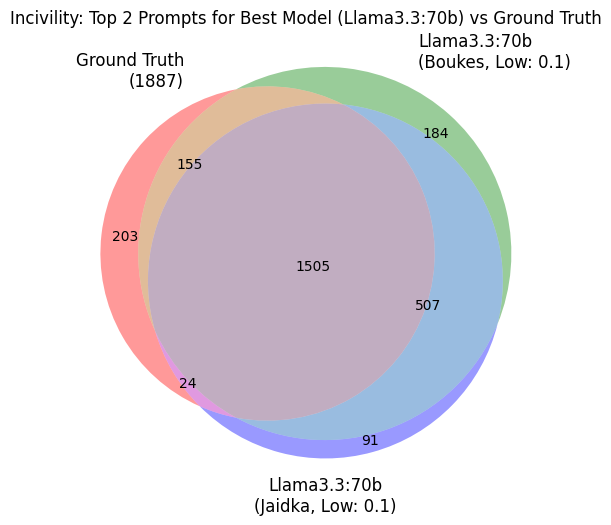

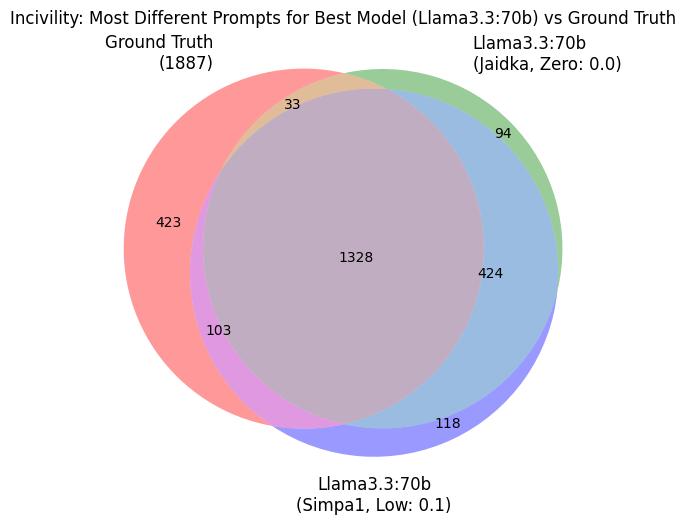


Generating Venn diagrams for: Rationality
Llama3.3:70b


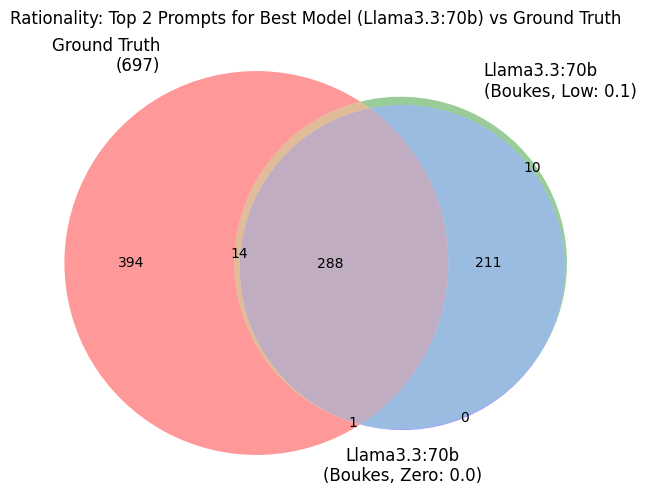

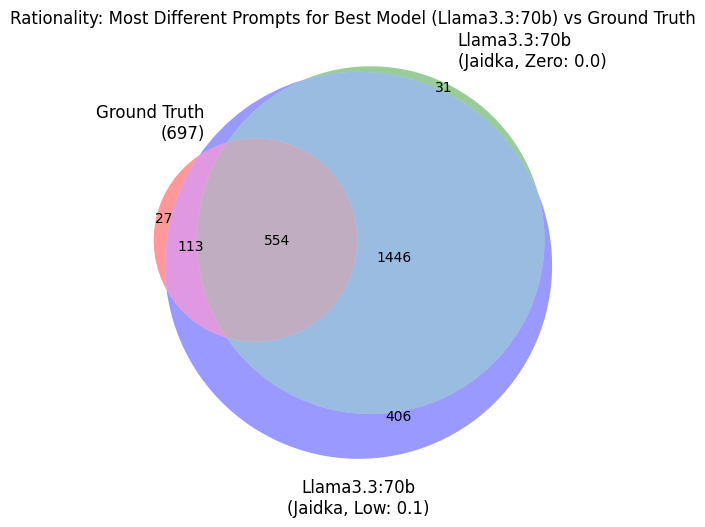


Generating Venn diagrams for: Interactivity
Llama3.3:70b


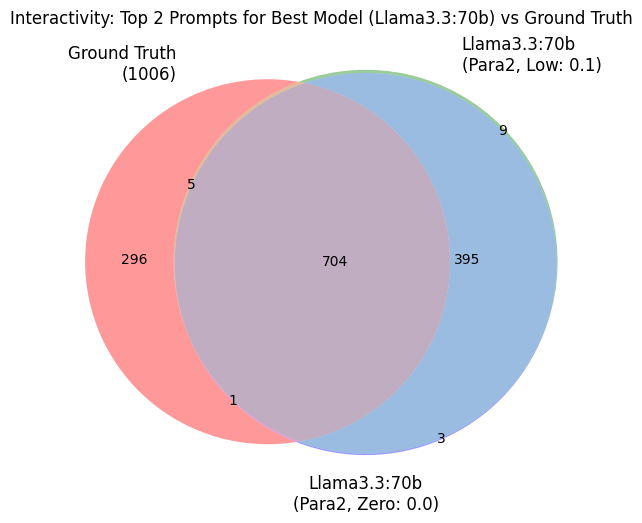

c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


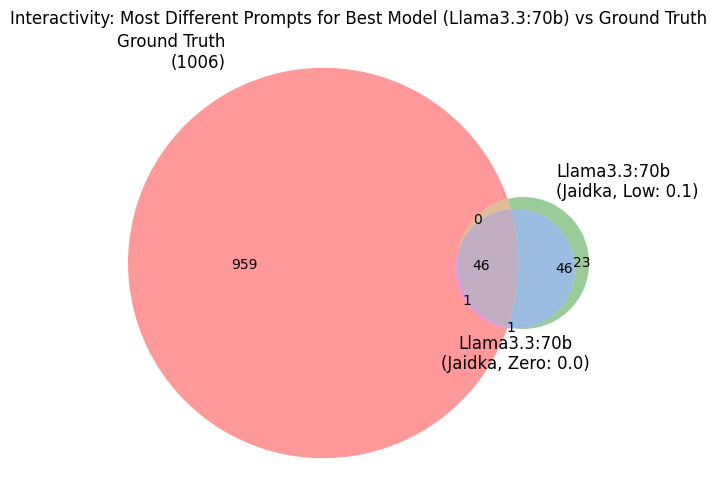


Generating Venn diagrams for: Liberal
GPT4o


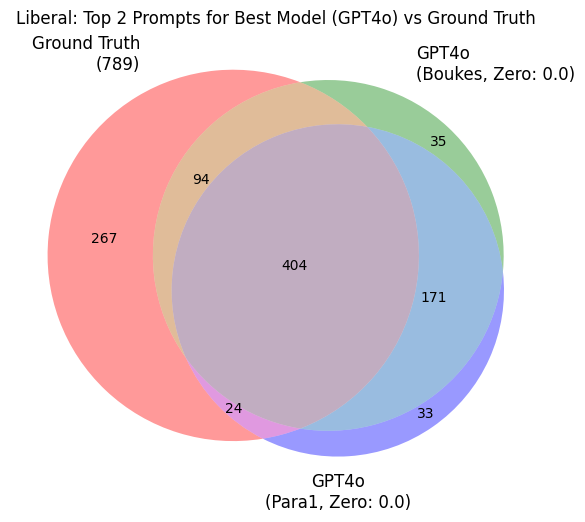

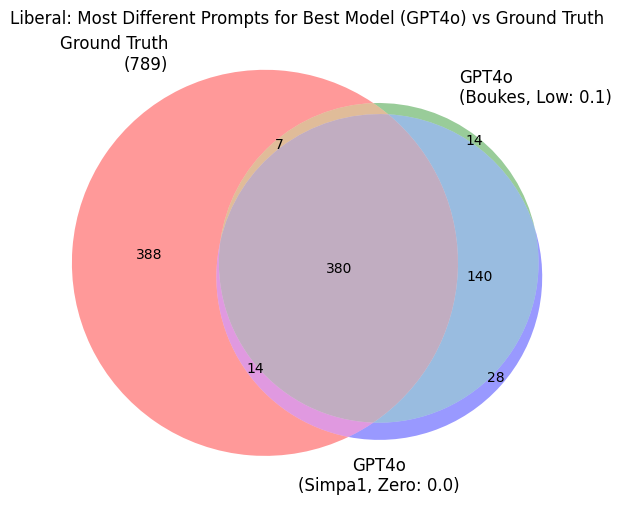


Generating Venn diagrams for: Conservative
GPT4o


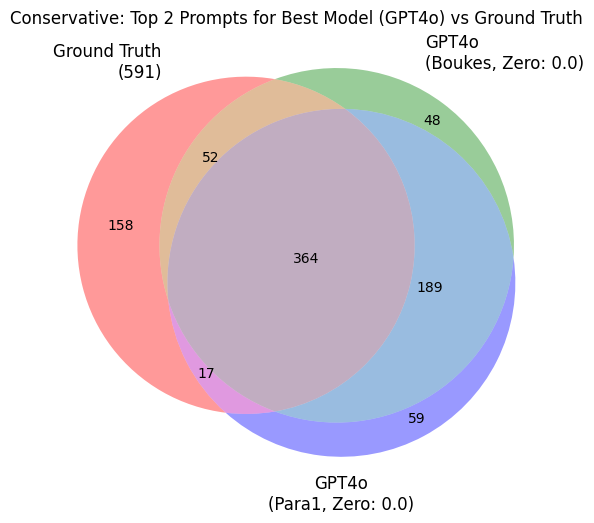

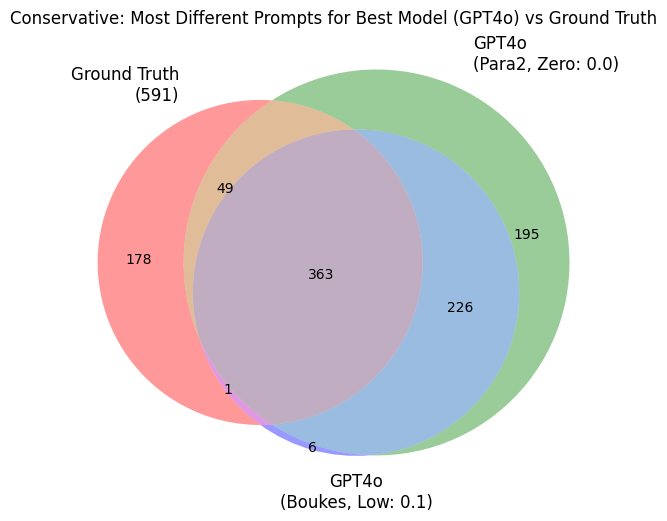


Generating Venn diagrams for: Political Post
Llama3.3:70b


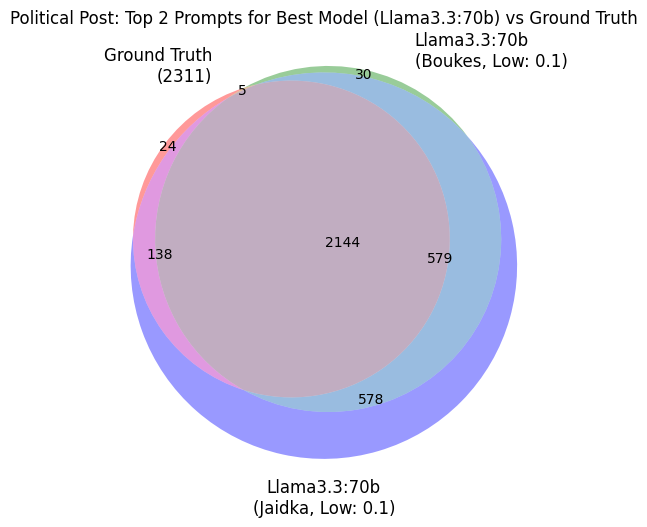

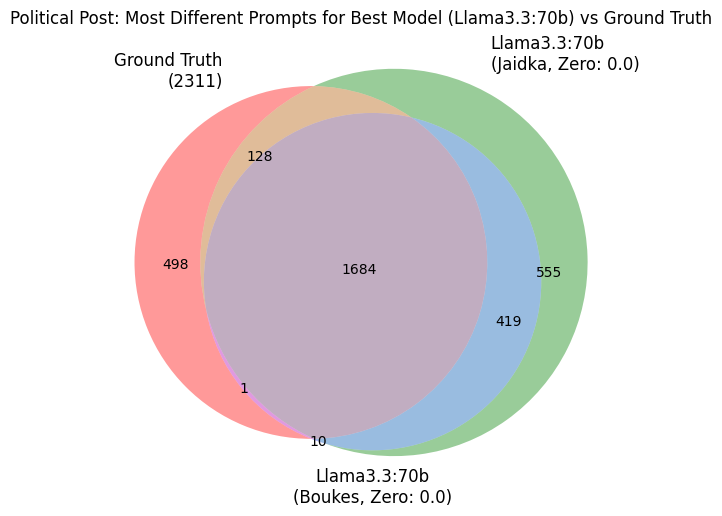

In [50]:
# Enhanced Venn diagrams for model and prompt overlaps with similarity analysis
def enhanced_venn_diagrams_for_models_and_prompts(concept_name, gt_col, dataset, model_columns_zero_boukes, model_columns_allprompts):
    """
    Generate comprehensive Venn diagrams including similarity analysis for prompt variants
    """
    gt_set = set(dataset[dataset[gt_col] == 1].index)
    
    # --- Part 1: Venns for Boukes zero prompt_variant ---
    # Build model performance for zero prompt_variant
    model_performance = []
    for col in model_columns_zero_boukes:
        labels = get_labels(col)
        if labels['concept'] == concept_name:  # Filter by concept
            model_name = labels['model']
            model_set = set(dataset[dataset[col] == 1].index)
            jaccard = len(gt_set & model_set) / len(gt_set | model_set) if len(gt_set | model_set) > 0 else 0
            model_performance.append((model_name, col, model_set, jaccard, labels))
    
    # Group by model, keep best prompt per model
    best_per_model = {}
    for model_name, col, model_set, jaccard, labels in model_performance:
        if model_name not in best_per_model or jaccard > best_per_model[model_name][2]:
            best_per_model[model_name] = (col, model_set, jaccard, labels)
    
    sorted_models = sorted(best_per_model.items(), key=lambda x: x[1][2], reverse=True)
    
    
    
    # --- Part 2: Venns for all prompt variants for best model ---
    sorted_models_no_gpt4t = [(model, data) for model, data in sorted_models if model != 'GPT4T']
    if len(sorted_models_no_gpt4t) >= 1:
        best_model = sorted_models_no_gpt4t[0][0]
        
        # All prompt variants for best model
        all_best_model_cols = [col for col in model_columns_alltemps 
                              if get_labels(col)['model'] == best_model and get_labels(col)['concept'] == concept_name]
        print(best_model)
        prompt_performance = []
        for col in all_best_model_cols:
            labels = get_labels(col)
            model_set = set(dataset[dataset[col] == 1].index)
            jaccard = len(gt_set & model_set) / len(gt_set | model_set) if len(gt_set | model_set) > 0 else 0
            prompt_performance.append((col, model_set, jaccard, labels))
        
        prompt_performance_sorted = sorted(prompt_performance, key=lambda x: x[2], reverse=True)
        
        # Venn 3: Top 2 prompts for best model
        if len(prompt_performance_sorted) >= 2:
            col1, set1, _, labels1 = prompt_performance_sorted[0]
            col2, set2, _, labels2 = prompt_performance_sorted[1]
            plt.figure(figsize=(8, 6))
            venn3([gt_set, set1, set2], 
                  set_labels=[f'Ground Truth\n({len(gt_set)})',
                             f'{best_model}\n({labels1["prompt_variant"]}, {labels1.get("temperature", "N/A")})',
                             f'{best_model}\n({labels2["prompt_variant"]}, {labels2.get("temperature", "N/A")})'])
            plt.title(f'{concept_name}: Top 2 Prompts for Best Model ({best_model}) vs Ground Truth')
            plt.show()
        
        # Venn 4: Two most different prompts for best model
        if len(prompt_performance_sorted) >= 2:
            col1, set1, _, labels1 = prompt_performance_sorted[-1]
            col2, set2, _, labels2 = prompt_performance_sorted[-2]
            plt.figure(figsize=(8, 6))
            venn3([gt_set, set1, set2], 
                  set_labels=[f'Ground Truth\n({len(gt_set)})',
                             f'{best_model}\n({labels1["prompt_variant"]}, {labels1.get("temperature", "N/A")})',
                             f'{best_model}\n({labels2["prompt_variant"]}, {labels2.get("temperature", "N/A")})'])
            plt.title(f'{concept_name}: Most Different Prompts for Best Model ({best_model}) vs Ground Truth')
            plt.show()
        
        
# Example usage for all concepts:
print("Generating enhanced Venn diagrams for all concepts...")
for concept_name, gt_col in boukes_concepts_info:
    print(f"\n{'='*60}")
    print(f"Generating Venn diagrams for: {concept_name}")
    print(f"{'='*60}")
    
    try:
        enhanced_venn_diagrams_for_models_and_prompts(
            concept_name=concept_name,
            gt_col=gt_col,
            dataset=boukes,
            model_columns_zero_boukes=model_columns_zero_boukes,
            model_columns_allprompts=model_columns_alltemps
        )
    except Exception as e:
        print(f"Error generating diagrams for {concept_name}: {e}")
        continue


GENERATING VENN DIAGRAMS: MOST DIFFERENT PROMPT VARIANTS ACROSS ALL MODELS

Most Different Prompt Variants for: Incivility


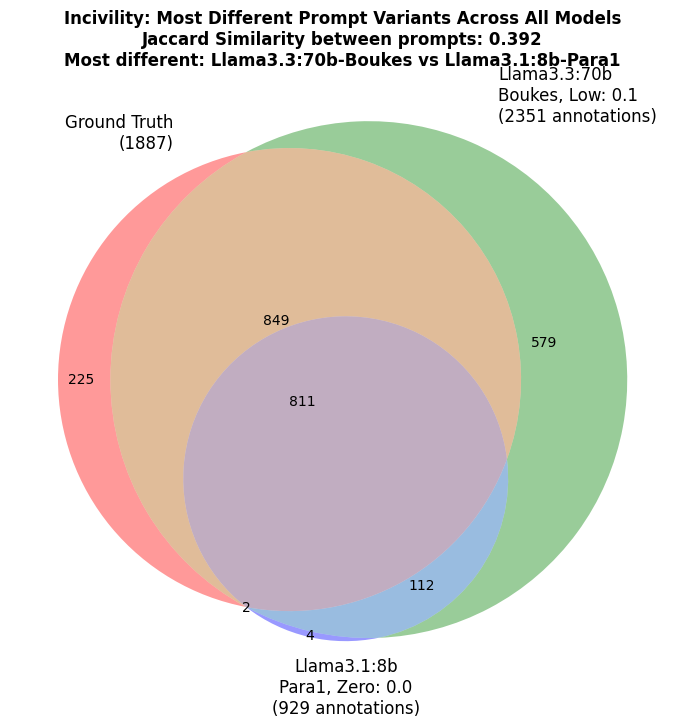


Most Different Prompt Variants Analysis for Incivility:
------------------------------------------------------------
Prompt 1: Llama3.3:70b - Boukes (Low: 0.1)
  Annotations: 2351, Overlap with GT: 1660 (88.0%)
Prompt 2: Llama3.1:8b - Para1 (Zero: 0.0)
  Annotations: 929, Overlap with GT: 813 (43.1%)
Similarity between prompts: 0.392
Common annotations between prompts: 923
Total unique annotations: 2357

Most Different Prompt Variants for: Rationality


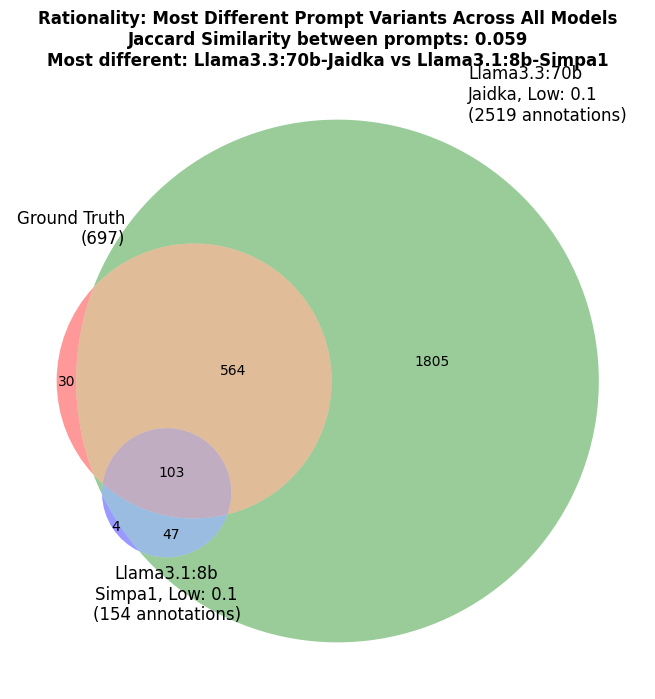


Most Different Prompt Variants Analysis for Rationality:
------------------------------------------------------------
Prompt 1: Llama3.3:70b - Jaidka (Low: 0.1)
  Annotations: 2519, Overlap with GT: 667 (95.7%)
Prompt 2: Llama3.1:8b - Simpa1 (Low: 0.1)
  Annotations: 154, Overlap with GT: 103 (14.8%)
Similarity between prompts: 0.059
Common annotations between prompts: 150
Total unique annotations: 2523

Most Different Prompt Variants for: Interactivity


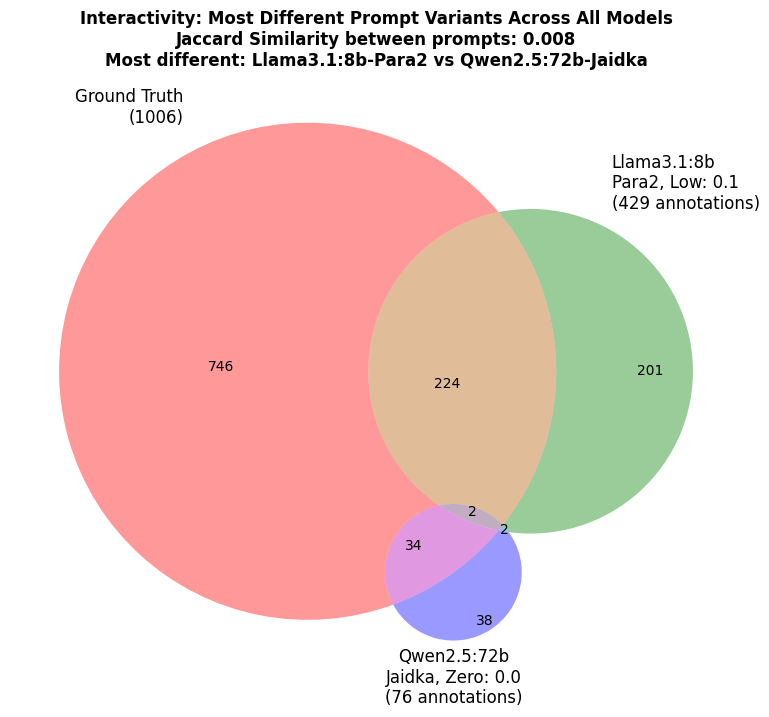


Most Different Prompt Variants Analysis for Interactivity:
------------------------------------------------------------
Prompt 1: Llama3.1:8b - Para2 (Low: 0.1)
  Annotations: 429, Overlap with GT: 226 (22.5%)
Prompt 2: Qwen2.5:72b - Jaidka (Zero: 0.0)
  Annotations: 76, Overlap with GT: 36 (3.6%)
Similarity between prompts: 0.008
Common annotations between prompts: 4
Total unique annotations: 501

Most Different Prompt Variants for: Liberal


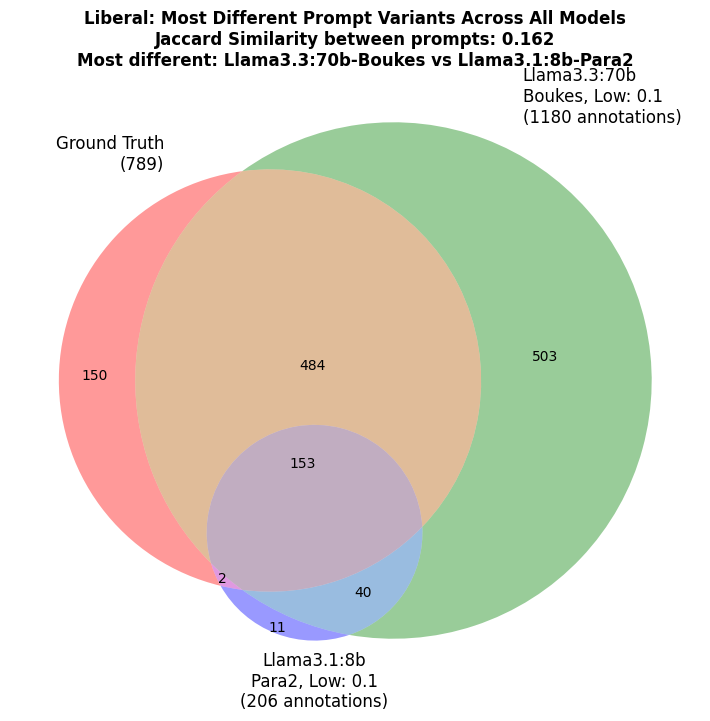


Most Different Prompt Variants Analysis for Liberal:
------------------------------------------------------------
Prompt 1: Llama3.3:70b - Boukes (Low: 0.1)
  Annotations: 1180, Overlap with GT: 637 (80.7%)
Prompt 2: Llama3.1:8b - Para2 (Low: 0.1)
  Annotations: 206, Overlap with GT: 155 (19.6%)
Similarity between prompts: 0.162
Common annotations between prompts: 193
Total unique annotations: 1193

Most Different Prompt Variants for: Conservative


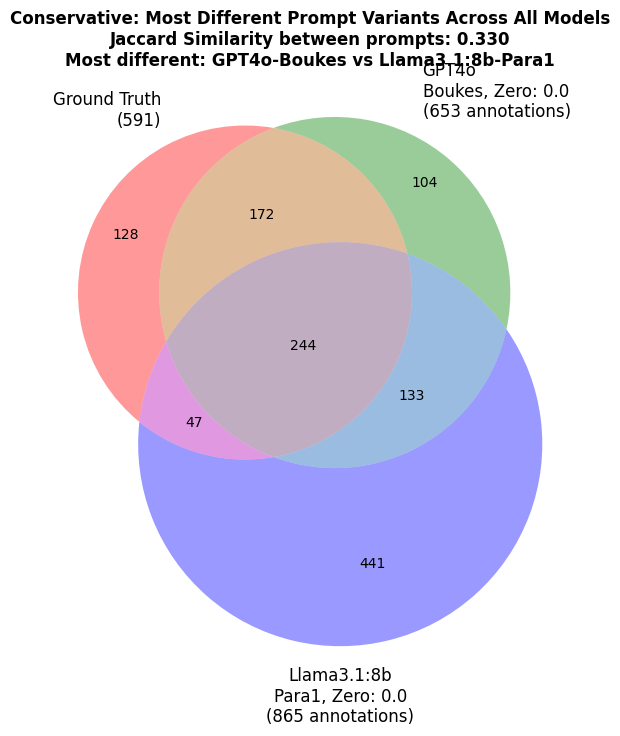


Most Different Prompt Variants Analysis for Conservative:
------------------------------------------------------------
Prompt 1: GPT4o - Boukes (Zero: 0.0)
  Annotations: 653, Overlap with GT: 416 (70.4%)
Prompt 2: Llama3.1:8b - Para1 (Zero: 0.0)
  Annotations: 865, Overlap with GT: 291 (49.2%)
Similarity between prompts: 0.330
Common annotations between prompts: 377
Total unique annotations: 1141

Most Different Prompt Variants for: Political Post


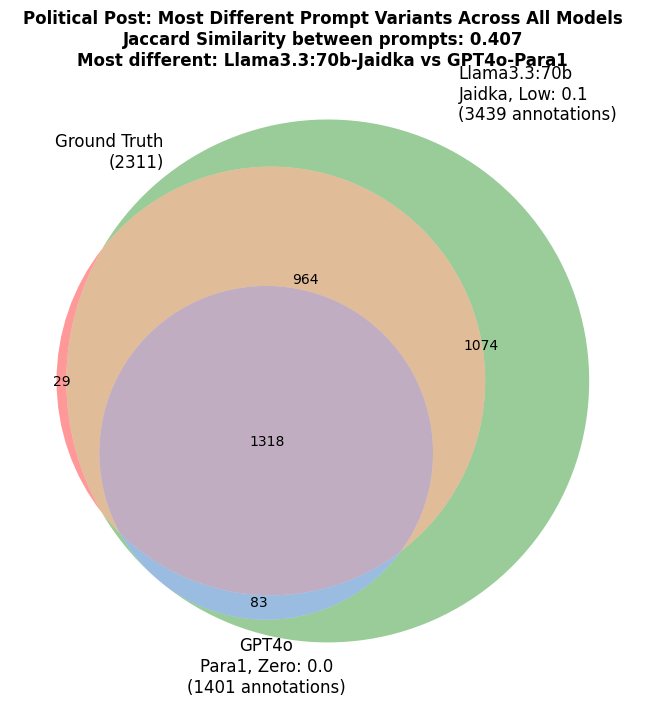


Most Different Prompt Variants Analysis for Political Post:
------------------------------------------------------------
Prompt 1: Llama3.3:70b - Jaidka (Low: 0.1)
  Annotations: 3439, Overlap with GT: 2282 (98.7%)
Prompt 2: GPT4o - Para1 (Zero: 0.0)
  Annotations: 1401, Overlap with GT: 1318 (57.0%)
Similarity between prompts: 0.407
Common annotations between prompts: 1401
Total unique annotations: 3439


In [52]:
# Venn diagram for most different prompt variants across all models per concept
def venn_most_different_prompts_across_models(concept_name, gt_col, dataset, model_columns_allprompts):
    """
    Generate a Venn diagram showing the overlap between ground truth and the two most different 
    prompt variants (regardless of which model they come from) for a given concept.
    """
    gt_set = set(dataset[dataset[gt_col] == 1].index)
    
    # Get all prompt variants for this concept (across all models)
    all_prompt_performance = []
    for col in model_columns_allprompts:
        labels = get_labels(col)
        if labels['concept'] == concept_name:
            model_name = labels['model']
            prompt_variant = labels['prompt_variant']
            temperature = labels.get('temperature', 'N/A')
            
            model_set = set(dataset[dataset[col] == 1].index)
            jaccard = len(gt_set & model_set) / len(gt_set | model_set) if len(gt_set | model_set) > 0 else 0
            
            all_prompt_performance.append((col, model_set, jaccard, labels, model_name, prompt_variant, temperature))
    
    if len(all_prompt_performance) < 2:
        print(f"Not enough prompt variants found for {concept_name}")
        return
    
    # Calculate pairwise Jaccard similarities between all prompt variants
    prompt_similarities = []
    for i, (col1, set1, jac1, labels1, model1, prompt1, temp1) in enumerate(all_prompt_performance):
        for j, (col2, set2, jac2, labels2, model2, prompt2, temp2) in enumerate(all_prompt_performance):
            if i < j:  # Avoid duplicates and self-comparison
                # Calculate Jaccard similarity between the two prompt annotation sets
                similarity = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0
                prompt_similarities.append((
                    similarity, 
                    col1, set1, labels1, model1, prompt1, temp1,
                    col2, set2, labels2, model2, prompt2, temp2
                ))
    
    if len(prompt_similarities) == 0:
        print(f"No prompt variant pairs found for {concept_name}")
        return
    
    # Sort by similarity (lowest to highest to get most different first)
    prompt_similarities_sorted = sorted(prompt_similarities, key=lambda x: x[0])
    
    # Get the two most different prompt variants (lowest Jaccard similarity)
    most_different = prompt_similarities_sorted[0]
    similarity, col1, set1, labels1, model1, prompt1, temp1, col2, set2, labels2, model2, prompt2, temp2 = most_different
    
    # Create Venn diagram
    plt.figure(figsize=(10, 8))
    venn3([gt_set, set1, set2], 
          set_labels=[
              f'Ground Truth\n({len(gt_set)})',
              f'{model1}\n{prompt1}, {temp1}\n({len(set1)} annotations)',
              f'{model2}\n{prompt2}, {temp2}\n({len(set2)} annotations)'
          ])
    
    plt.title(f'{concept_name}: Most Different Prompt Variants Across All Models\n'
              f'Jaccard Similarity between prompts: {similarity:.3f}\n'
              f'Most different: {model1}-{prompt1} vs {model2}-{prompt2}', 
              fontsize=12, fontweight='bold')
    plt.show()
    
    # Print additional statistics
    print(f"\nMost Different Prompt Variants Analysis for {concept_name}:")
    print("-" * 60)
    print(f"Prompt 1: {model1} - {prompt1} ({temp1})")
    print(f"  Annotations: {len(set1)}, Overlap with GT: {len(gt_set & set1)} ({len(gt_set & set1)/len(gt_set)*100:.1f}%)")
    print(f"Prompt 2: {model2} - {prompt2} ({temp2})")
    print(f"  Annotations: {len(set2)}, Overlap with GT: {len(gt_set & set2)} ({len(gt_set & set2)/len(gt_set)*100:.1f}%)")
    print(f"Similarity between prompts: {similarity:.3f}")
    print(f"Common annotations between prompts: {len(set1 & set2)}")
    print(f"Total unique annotations: {len(set1 | set2)}")


# Generate most different prompt variants Venn diagrams for all concepts
print("\n" + "="*80)
print("GENERATING VENN DIAGRAMS: MOST DIFFERENT PROMPT VARIANTS ACROSS ALL MODELS")
print("="*80)

for concept_name, gt_col in boukes_concepts_info:
    print(f"\n{'='*60}")
    print(f"Most Different Prompt Variants for: {concept_name}")
    print(f"{'='*60}")
    
    try:
        venn_most_different_prompts_across_models(
            concept_name=concept_name,
            gt_col=gt_col,
            dataset=boukes,
            model_columns_allprompts=model_columns_alltemps
        )
    except Exception as e:
        print(f"Error generating diagram for {concept_name}: {e}")
        continue